# Function Testing Notebook - Joseph

This notebook is meant to test external-facing functions to ensure they are working as expected.

A dedicated test_all_functions.py with unit testing might be better, but this is a good benchmark

In [1]:
import logging
import os
import sys
import tempfile
import time
from pathlib import Path

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
from dask.distributed import Client, LocalCluster
from dask_jobqueue import SLURMCluster

In [2]:
from pythoneeg import constants, core, visualization

print(core.__all__)
# print(visualization.__all__)
# print(dir(constants))

/mnt/isilon/marsh_single_unit/PythonEEG/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['DDFBinaryMetadata', 'LongRecordingOrganizer', 'convert_ddfcolbin_to_ddfrowbin', 'convert_ddfrowbin_to_si', 'convert_units_to_multiplier', 'convert_colpath_to_rowpath', 'filepath_to_index', 'is_day', 'set_temp_directory', 'get_temp_directory', 'parse_path_to_animalday', 'parse_str_to_genotype', 'parse_str_to_animal', 'parse_str_to_day', 'parse_chname_to_abbrev', 'nanaverage', 'LongRecordingAnalyzer', 'MountainSortAnalyzer', 'FragmentAnalyzer', '_log_transform']


In [3]:
tempdir = Path('../../tmp').resolve()
print(tempdir)
core.set_temp_directory(tempdir)

/mnt/isilon/marsh_single_unit/PythonEEG/tmp


In [4]:
data_folder = Path('./test-data').resolve()
lrec = core.LongRecordingOrganizer(base_folder_path= data_folder / 'A10 KO 12_13_2023',
                                    truncate=3)
lrec.convert_colbins_to_rowbins(overwrite=False)
lrec.convert_rowbins_to_rec()

/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/core/core.py:220: UserWarning: LongRecording will be truncated to the first 3 files
  warnings.warn(f"LongRecording will be truncated to the first {self.n_truncate} files")


In [5]:
Path('./test-wars/A5').resolve()

PosixPath('/mnt/isilon/marsh_single_unit/PythonEEG/notebooks/tests/test-wars/A5')

In [6]:
# Set up logger with detailed formatting
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG, stream=sys.stdout, force=True)
logger = logging.getLogger()


In [7]:
%%script true

cluster = LocalCluster()
display(cluster)

# animal_ids = ['A5', 'A10', 'F22', 'G25', 'G26', 'N21', 'N22', 'N23', 'N24', 'N25']
# animal_ids = ['A5', 'A10']
# animal_ids = []
# animal_ids = ['A5']
# animal_ids = ['A10']
animal_ids = ["F22"]
# animal_ids = ['G25']
base_folder = Path("./test-data").resolve()
# base_folder = Path('/mnt/isilon/marsh_single_unit/PythonEEG Data Bins').resolve()
for animal_id in animal_ids:
    ao = visualization.AnimalOrganizer(base_folder, animal_id, mode="concat", assume_from_number=True, truncate=False)
    ao.convert_colbins_to_rowbins(overwrite=False)
    ao.convert_rowbins_to_rec()  # parallelization breaks if not enough memory

    ao.compute_bad_channels()

    with Client(cluster) as client:
        # client.upload_file(str(packageroot / 'pythoneeg.zip'))
        display(client)
        print("running war")
        # ao.convert_rowbins_to_rec(multiprocess_mode='dask') # paralleization breaks if not enough memory
        war = ao.compute_windowed_analysis(["all"], multiprocess_mode="serial")
    #     war.save_pickle_and_json(Path(f'./test-wars-full/{animal_id}').resolve())

    # with Client(cluster) as client:
    #     client.upload_file(str(packageroot / 'pythoneeg.zip'))
    #     display(client)
    #     print("running sar")
    #     sar = ao.compute_spike_analysis(multiprocess_mode='dask')

2025-06-12 18:10:11,189 - DEBUG - Using selector: EpollSelector


In [8]:
# df = pd.read_pickle('/mnt/isilon/marsh_single_unit/PythonEEG/notebooks/tests/test-wars-full/031621_cohort 2 group 2 and group 5 F6/f6-fhet.pkl')
# display(df)

In [9]:
war = visualization.WindowAnalysisResult.load_pickle_and_json(Path('./test-wars/A10').resolve())
# war = visualization.WindowAnalysisResult.load_pickle_and_json(Path('/mnt/isilon/marsh_single_unit/PythonEEG/notebooks/tests/test-wars-sox5-2/061022_group 9 M1, M2, M3 group9_M1_Cage1').resolve())
# war.result = war.result.head(2)
res1 = war.get_result(['all'], allow_missing=True)
# war.aggregate_time_windows()
war.add_unique_hash()
war.filter_all()
res2 = war.get_result(['all'], allow_missing=True)

# with pd.option_context('display.max_rows', None, 'display.max_columns', None, 
#                       'display.max_colwidth', 1000, 'display.width', None):
display(res1)
display(res2)

2025-06-12 18:10:11,381 - WARNING - Intan Input (1)/PortC C-009 does not match name aliases. Assuming alias from number in channel name.
2025-06-12 18:10:11,383 - WARNING - Intan Input (1)/PortC C-010 does not match name aliases. Assuming alias from number in channel name.
2025-06-12 18:10:11,384 - WARNING - Intan Input (1)/PortC C-012 does not match name aliases. Assuming alias from number in channel name.
2025-06-12 18:10:11,385 - WARNING - Intan Input (1)/PortC C-014 does not match name aliases. Assuming alias from number in channel name.
2025-06-12 18:10:11,387 - WARNING - Intan Input (1)/PortC C-015 does not match name aliases. Assuming alias from number in channel name.
2025-06-12 18:10:11,388 - WARNING - Intan Input (1)/PortC C-016 does not match name aliases. Assuming alias from number in channel name.
2025-06-12 18:10:11,388 - WARNING - Intan Input (1)/PortC C-017 does not match name aliases. Assuming alias from number in channel name.
2025-06-12 18:10:11,390 - WARNING - Intan

/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/results.py:476: UserWarning: Dropping column 'index'
  warnings.warn("Dropping column 'index'")


Channel names: 	['Intan Input (1)/PortC C-009', 'Intan Input (1)/PortC C-010', 'Intan Input (1)/PortC C-012', 'Intan Input (1)/PortC C-014', 'Intan Input (1)/PortC C-015', 'Intan Input (1)/PortC C-016', 'Intan Input (1)/PortC C-017', 'Intan Input (1)/PortC C-019', 'Intan Input (1)/PortC C-021', 'Intan Input (1)/PortC C-022']
Channel abbreviations: 	['LAud', 'LVis', 'LHip', 'LBar', 'LMot', 'RMot', 'RBar', 'RHip', 'RVis', 'RAud']


,animalday,animal,day,genotype,duration,endfile,timestamp,isday,rms,ampvar,...,logampvar,logpsdtotal,lognspike,psdband,psdfrac,logpsdband,logpsdfrac,cohere,pcorr,psd
0,A10 KO Dec-13-2023,A10,2023-12-13,KO,4.00,None,2023-12-13 11:15:31.640,True,"[45.94368, 79.14001, 35.04157, 72.76703, 49.01...","[2109.176, 6243.486, 1227.7976, 5292.858, 2394...",...,NaN,NaN,NaN,"{'delta': [1880.6408494145003, 2076.6261729215...","{'delta': [0.8757337424183906, 0.3662919221944...",NaN,NaN,"{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,..."
1,A10 KO Dec-13-2023,A10,2023-12-13,KO,4.00,None,2023-12-13 11:15:35.640,True,"[17.3866, 104.45948, 17.702438, 87.68797, 40.2...","[300.91333, 10911.767, 312.74246, 7676.2554, 1...",...,NaN,NaN,NaN,"{'delta': [113.76098938297639, 4511.0967970262...","{'delta': [0.5477649832278584, 0.4391228648288...",NaN,NaN,"{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,..."
2,A10 KO Dec-13-2023,A10,2023-12-13,KO,4.00,None,2023-12-13 11:15:39.640,True,"[21.215878, 101.42183, 17.911005, 85.187965, 4...","[448.86813, 10286.336, 319.6559, 7256.154, 234...",...,NaN,NaN,NaN,"{'delta': [217.7492768576539, 3193.64854289847...","{'delta': [0.6220572814117793, 0.3419873648782...",NaN,NaN,"{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,..."
3,A10 KO Dec-13-2023,A10,2023-12-13,KO,4.00,None,2023-12-13 11:15:43.640,True,"[16.124065, 86.00607, 14.081838, 77.030235, 47...","[258.8584, 7396.58, 197.52907, 5932.8706, 2249...",...,NaN,NaN,NaN,"{'delta': [144.8385593070696, 2967.68896319986...","{'delta': [0.7048391537193266, 0.5112613351612...",NaN,NaN,"{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,..."
4,A10 KO Dec-13-2023,A10,2023-12-13,KO,4.00,None,2023-12-13 11:15:47.640,True,"[18.514662, 95.01182, 19.664528, 86.265015, 54...","[342.50107, 9017.06, 386.69186, 7437.023, 2952...",...,NaN,NaN,NaN,"{'delta': [179.50505469645486, 5810.3040725743...","{'delta': [0.7386329423169761, 0.6728297396813...",NaN,NaN,"{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,..."
5,A10 KO Dec-13-2023,A10,2023-12-13,KO,4.00,None,2023-12-13 11:15:51.640,True,"[23.87738, 95.44384, 23.737915, 80.19445, 50.5...","[568.7844, 9108.109, 562.6703, 6429.945, 2554....",...,NaN,NaN,NaN,"{'delta': [120.49037335560443, 3713.2874509882...","{'delta': [0.5646004788112214, 0.4688006221090...",NaN,NaN,"{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,..."
6,A10 KO Dec-13-2023,A10,2023-12-13,KO,4.00,None,2023-12-13 11:15:55.640,True,"[17.575134, 114.56625, 16.799383, 84.014496, 3...","[308.21622, 13100.094, 281.6556, 7058.051, 139...",...,NaN,NaN,NaN,"{'delta': [105.51363576643743, 4303.0042947408...","{'delta': [0.5969533253987602, 0.3359227099275...",NaN,NaN,"{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,..."
7,A10 KO Dec-13-2023,A10,2023-12-13,KO,4.00,None,2023-12-13 11:15:59.640,True,"[18.340143, 83.75154, 15.620064, 96.09968, 40....","[335.41827, 7007.6655, 241.92842, 9235.023, 16...",...,NaN,NaN,NaN,"{'delta': [175.6420327783639, 1057.55050827150...","{'delta': [0.666916224472279, 0.16026306994121...",NaN,NaN,"{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,..."
8,A10 KO Dec-13-2023,A10,2023-12-13,KO,4.00,None,2023-12-13 11:16:03.640,True,"[17.474148, 109.268486, 12.

,animalday,animal,day,genotype,duration,endfile,timestamp,isday,rms,ampvar,...,logampvar,logpsdtotal,lognspike,psdband,psdfrac,logpsdband,logpsdfrac,cohere,pcorr,psd
0,A10_a6a7994aeca52d78c67924a452c4c9a50bdf40cf96...,A10_a6a7994aeca52d78c67924a452c4c9a50bdf40cf96...,2023-12-13,KO,4.00,None,2023-12-13 11:15:31.640,True,"[45.94367980957031, 79.14000701904297, 35.0415...","[2109.176025390625, 6243.48583984375, 1227.797...",...,NaN,NaN,NaN,"{'delta': [1880.6408494145003, 2076.6261729215...","{'delta': [0.8757337424183906, 0.3662919221944...",NaN,NaN,"{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,..."
1,A10_a6a7994aeca52d78c67924a452c4c9a50bdf40cf96...,A10_a6a7994aeca52d78c67924a452c4c9a50bdf40cf96...,2023-12-13,KO,4.00,None,2023-12-13 11:15:35.640,True,"[nan, 104.45948028564453, nan, 87.687973022460...","[nan, 10911.7666015625, nan, 7676.25537109375,...",...,NaN,NaN,NaN,"{'delta': [nan, 4511.096797026267, nan, 3018.0...","{'delta': [nan, 0.43912286482888296, nan, 0.41...",NaN,NaN,"{'delta': [[nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,..."
2,A10_a6a7994aeca52d78c67924a452c4c9a50bdf40cf96...,A10_a6a7994aeca52d78c67924a452c4c9a50bdf40cf96...,2023-12-13,KO,4.00,None,2023-12-13 11:15:39.640,True,"[nan, 101.42182922363281, nan, 85.187965393066...","[nan, 10286.3359375, nan, 7256.15380859375, 23...",...,NaN,NaN,NaN,"{'delta': [nan, 3193.648542898477, nan, 2274.9...","{'delta': [nan, 0.34198736487829273, nan, 0.37...",NaN,NaN,"{'delta': [[nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,..."
3,A10_a6a7994aeca52d78c67924a452c4c9a50bdf40cf96...,A10_a6a7994aeca52d78c67924a452c4c9a50bdf40cf96...,2023-12-13,KO,4.00,None,2023-12-13 11:15:43.640,True,"[nan, 86.00607299804688, nan, 77.0302352905273...","[nan, 7396.580078125, nan, 5932.87060546875, 2...",...,NaN,NaN,NaN,"{'delta': [nan, 2967.6889631998647, nan, 2569....","{'delta': [nan, 0.5112613351612891, nan, 0.443...",NaN,NaN,"{'delta': [[nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,..."
4,A10_a6a7994aeca52d78c67924a452c4c9a50bdf40cf96...,A10_a6a7994aeca52d78c67924a452c4c9a50bdf40cf96...,2023-12-13,KO,4.00,None,2023-12-13 11:15:47.640,True,"[nan, 95.0118179321289, nan, 86.2650146484375,...","[nan, 9017.0595703125, nan, 7437.02294921875, ...",...,NaN,NaN,NaN,"{'delta': [nan, 5810.30407257437, nan, 4238.54...","{'delta': [nan, 0.6728297396813799, nan, 0.561...",NaN,NaN,"{'delta': [[nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,..."
5,A10_a6a7994aeca52d78c67924a452c4c9a50bdf40cf96...,A10_a6a7994aeca52d78c67924a452c4c9a50bdf40cf96...,2023-12-13,KO,4.00,None,2023-12-13 11:15:51.640,True,"[nan, 95.44384002685547, nan, 80.1944503784179...","[nan, 9108.109375, nan, 6429.94482421875, 2554...",...,NaN,NaN,NaN,"{'delta': [nan, 3713.2874509882477, nan, 1649....","{'delta': [nan, 0.46880062210900664, nan, 0.26...",NaN,NaN,"{'delta': [[nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,..."
6,A10_a6a7994aeca52d78c67924a452c4c9a50bdf40cf96...,A10_a6a7994aeca52d78c67924a452c4c9a50bdf40cf96...,2023-12-13,KO,4.00,None,2023-12-13 11:15:55.640,True,"[nan, 114.56625366210938, nan, 84.014495849609...","[nan, 13100.09375, nan, 7058.05078125, 1391.23...",...,NaN,NaN,NaN,"{'delta': [nan, 4303.004294740878, nan, 2735.3...","{'delta': [nan, 0.3359227099275248, nan, 0.482...",NaN,NaN,"{'delta': [[nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,..."
7,A10_a6a7994aeca52d78c67924a452c

In [10]:
print(war.bad_channels_dict)
# war.get_filter_reject_channels_by_recording_session()
# war.filter_all()

{}


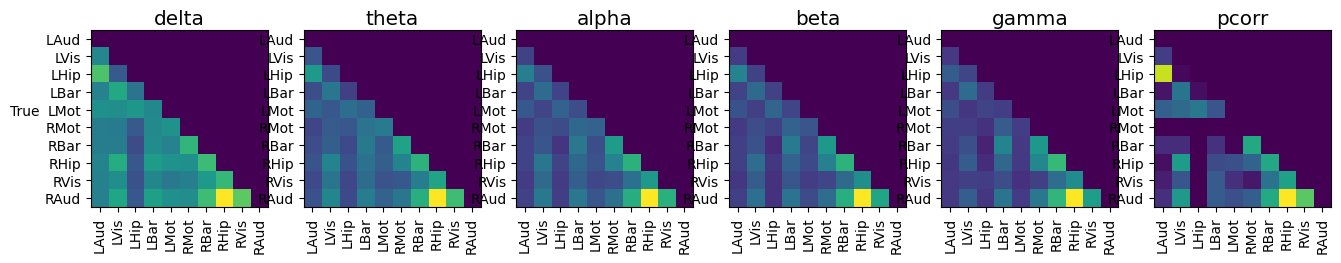

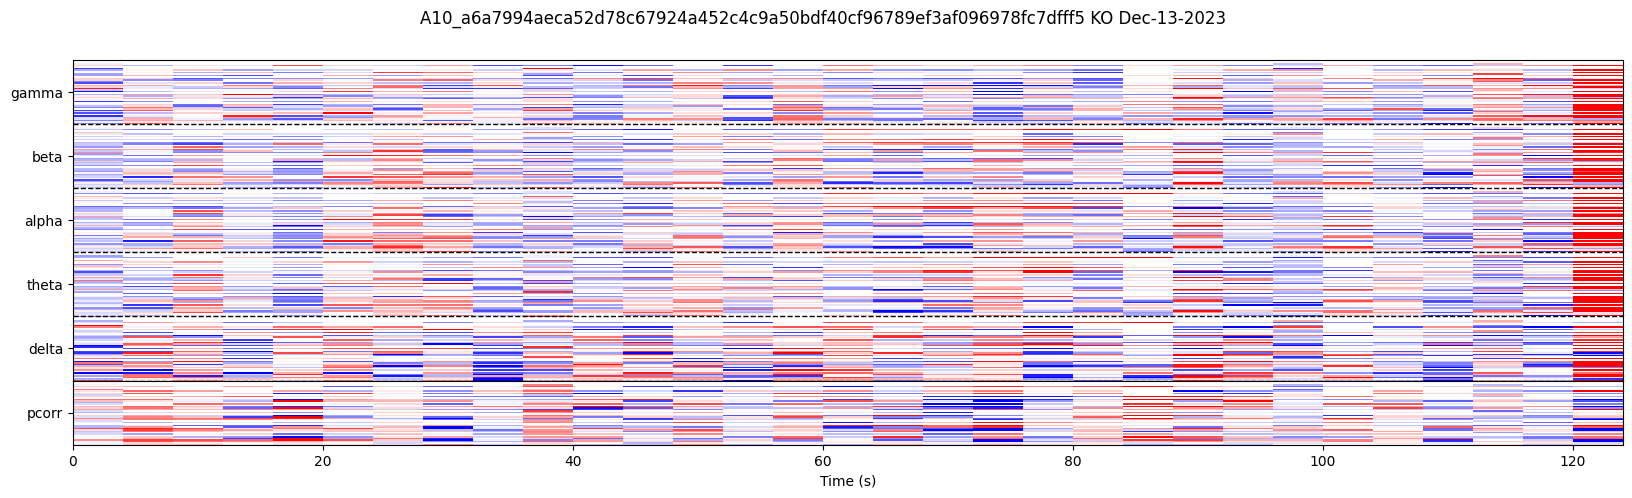

/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/animal.py:411: RuntimeWarning: divide by zero encountered in log10
  ax[0, i].plot(freqs, 10 ** (b + m * np.log10(freqs)), c=f"C{j}", alpha=0.75)


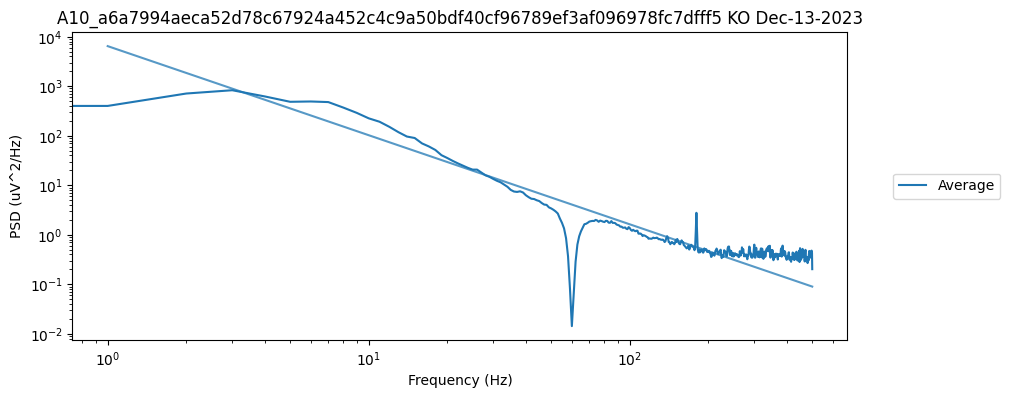

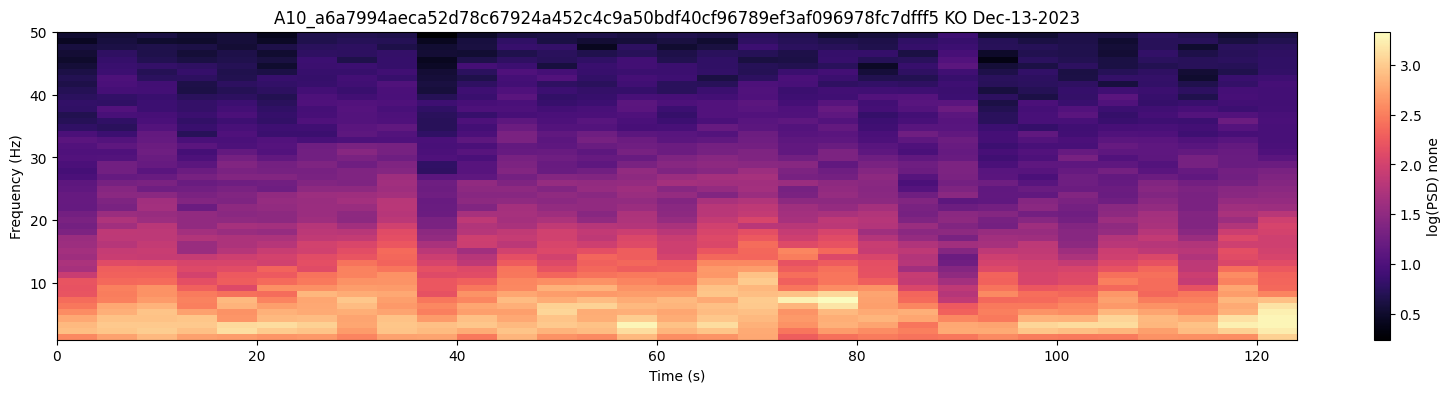

In [11]:
logger.setLevel(logging.WARNING)
ap = visualization.AnimalPlotter(war)
ap.plot_coherecorr_matrix(['isday'], bands=None, figsize=(16,5), cmap='viridis')
# ap.plot_coherecorr_diff(['isday'], bands=None, figsize=(16,5))
# ap.plot_linear_temporal(figsize=(20, 5), score_type='z', lw=1, channels=[0, 1])
# ap.plot_linear_temporal(['isday'], figsize=(20, 5), score_type='z', lw=1, channels=[0, 1, 2, 3])

# ap.plot_coherecorr_spectral(['isday'], figsize=(20, 5), score_type='center')

ap.plot_coherecorr_spectral(figsize=(20, 5), score_type='center')
ap.plot_psd_histogram(figsize=(10, 4), avg_channels=True, plot_type='loglog')
ap.plot_psd_spectrogram(figsize=(20, 4), mode='none')

In [12]:
logger.setLevel(logging.DEBUG)
wars = []
# animal_ids = ['A5', 'A10', 'F22']
animal_ids = [p for p in Path("./test-wars-sox5-collapsed").glob("*") if p.is_dir()]
# bad_animal_ids = []
bad_animal_ids = ['MHET_89db8ce8', 'FHET(2)_7e92370a', 'MMUT_f09c2e61', 'OLDMMT_afefdead', 'M3_0f0e3317']
print([p.name for p in animal_ids])

for i, animal_id in enumerate(animal_ids):
    if animal_id.name not in bad_animal_ids:
        war = visualization.WindowAnalysisResult.load_pickle_and_json(animal_id)
        # war.filter_all()
        # war.aggregate_time_windows()
        wars.append(war)

ep = visualization.ExperimentPlotter(
    wars=wars,
    exclude=["nspike", "lognspike"],
    # exclude=["nspike", "psdfrac", "logrms", "logampvar", "logpsdtotal", "lognspike", "logpsdband", "logpsdfrac"],
)


['CM5_1ec067e1', 'FHET_8839b9e6', 'MMUT_f673ae75', 'MHET_89db8ce8', 'M10_057ac053', 'MMUT_41a8fa8a', 'mouse M5 cage4A_04465616', 'M7_9a66f97d', 'mouse M3 cage3A_aab9b3ce', 'OLDMMT_afefdead', 'FMUT__67cd66f5', 'M2_878c2985', 'F9_3d24ce3d', 'DF3_76bd9e10', 'M8_ee84438b', 'AM5_a0b5c76d', 'FWT_a95ec855', 'group9_M3_Cage 4_07f663b5', 'M2_cd733b47', '#8 Cage 3A_abf9616a', '040221_Group 1 Mouse 9 Recording_f6997e68', 'AM3_cbcb5d3d', 'FMUT_dd0c45cf', 'IF5_4a790bcc', 'F4_659af55b', 'GF4_16c6b108', 'AM4_3637a788', 'M2_ebc6a73b', 'CF2_1788581c', 'F10_f8966d9d', 'MMUT(1)_2be31283', '#8 Cage 1A_0f8bc207', 'M3_0f0e3317', 'F5_547fffb6', 'FMUT_ad6ef807', 'CF1_5166d73e', 'MMUT(2)_fa3eb59b', 'FHET(2)_7e92370a', 'mouse M5 cage2A_18a02032', 'FF6_2925944a', 'FMUT_dfc062ff', 'FMUT_d1994fd2', 'CM9_bec51a4c', 'M10_ae7f87f5', 'F7_f56aa67a', 'mouse M3 cage1A_a3b7a78d', '#3 Cage 4A_c4828112', 'group9_M2_Cage 3_a228cdaa', 'M8_bcc9af8b', 'M3_108abec4', 'BM6_c2c3a692', 'BF3_13cb0628', 'F6_0fc774f1', 'MMUT_f09c2e61'

/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:193: RuntimeWarning: Mean of empty slice
  vals = np.nanmean(vals[:, tril_indices[0], tril_indices[1]], axis=-1)


,animal,genotype,isday,pcorr,sex,gene
18,BF3_13cb0628,FWT,Night,0.748051,Female,WT
19,BF3_13cb0628,FWT,Day,0.723311,Female,WT
22,CF1_5166d73e,FWT,Night,0.300687,Female,WT
23,CF1_5166d73e,FWT,Day,0.297717,Female,WT
24,CF2_1788581c,FWT,Night,0.749730,Female,WT
...,...,...,...,...,...,...
101,MMUT_f673ae75,MMut,Day,0.406237,Male,Mut
110,mouse M5 cage2A_18a02032,MMut,Night,0.249845,Male,Mut
111,mouse M5 cage2A_18a02032,MMut,Day,0.129247,Male,Mut
112,mouse M5 cage4A_04465616,MMut,Night,0.354347,Male,Mut


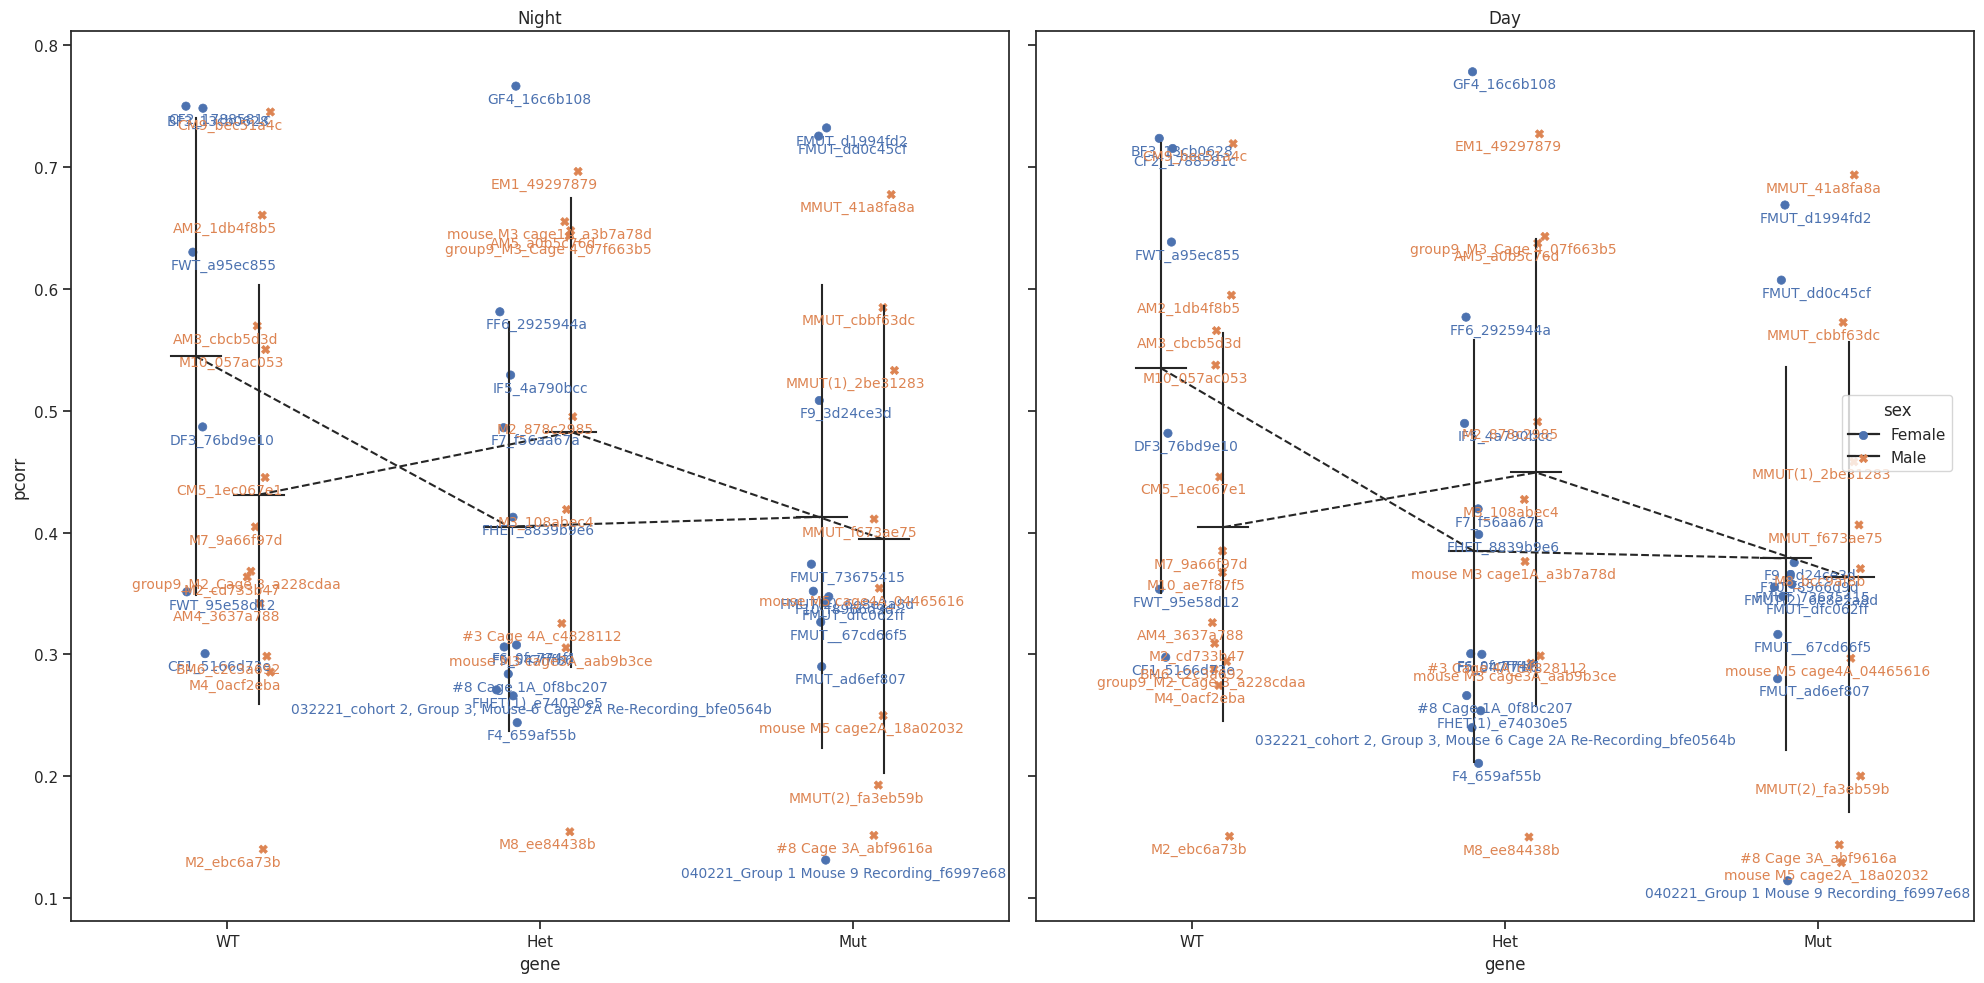

/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:208: RuntimeWarning: Mean of empty slice
  vals = np.nanmean(vals[:, :, tril_indices[0], tril_indices[1]], axis=-1)
/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:208: RuntimeWarning: Mean of empty slice
  vals = np.nanmean(vals[:, :, tril_indices[0], tril_indices[1]], axis=-1)


,animal,genotype,isday,cohere,sex,gene
18,BF3_13cb0628,FWT,Night,0.791713,Female,WT
19,BF3_13cb0628,FWT,Day,0.782654,Female,WT
22,CF1_5166d73e,FWT,Night,0.620439,Female,WT
23,CF1_5166d73e,FWT,Day,0.614902,Female,WT
24,CF2_1788581c,FWT,Night,0.843723,Female,WT
...,...,...,...,...,...,...
101,MMUT_f673ae75,MMut,Day,0.615861,Male,Mut
110,mouse M5 cage2A_18a02032,MMut,Night,0.546056,Male,Mut
111,mouse M5 cage2A_18a02032,MMut,Day,0.485292,Male,Mut
112,mouse M5 cage4A_04465616,MMut,Night,0.404561,Male,Mut


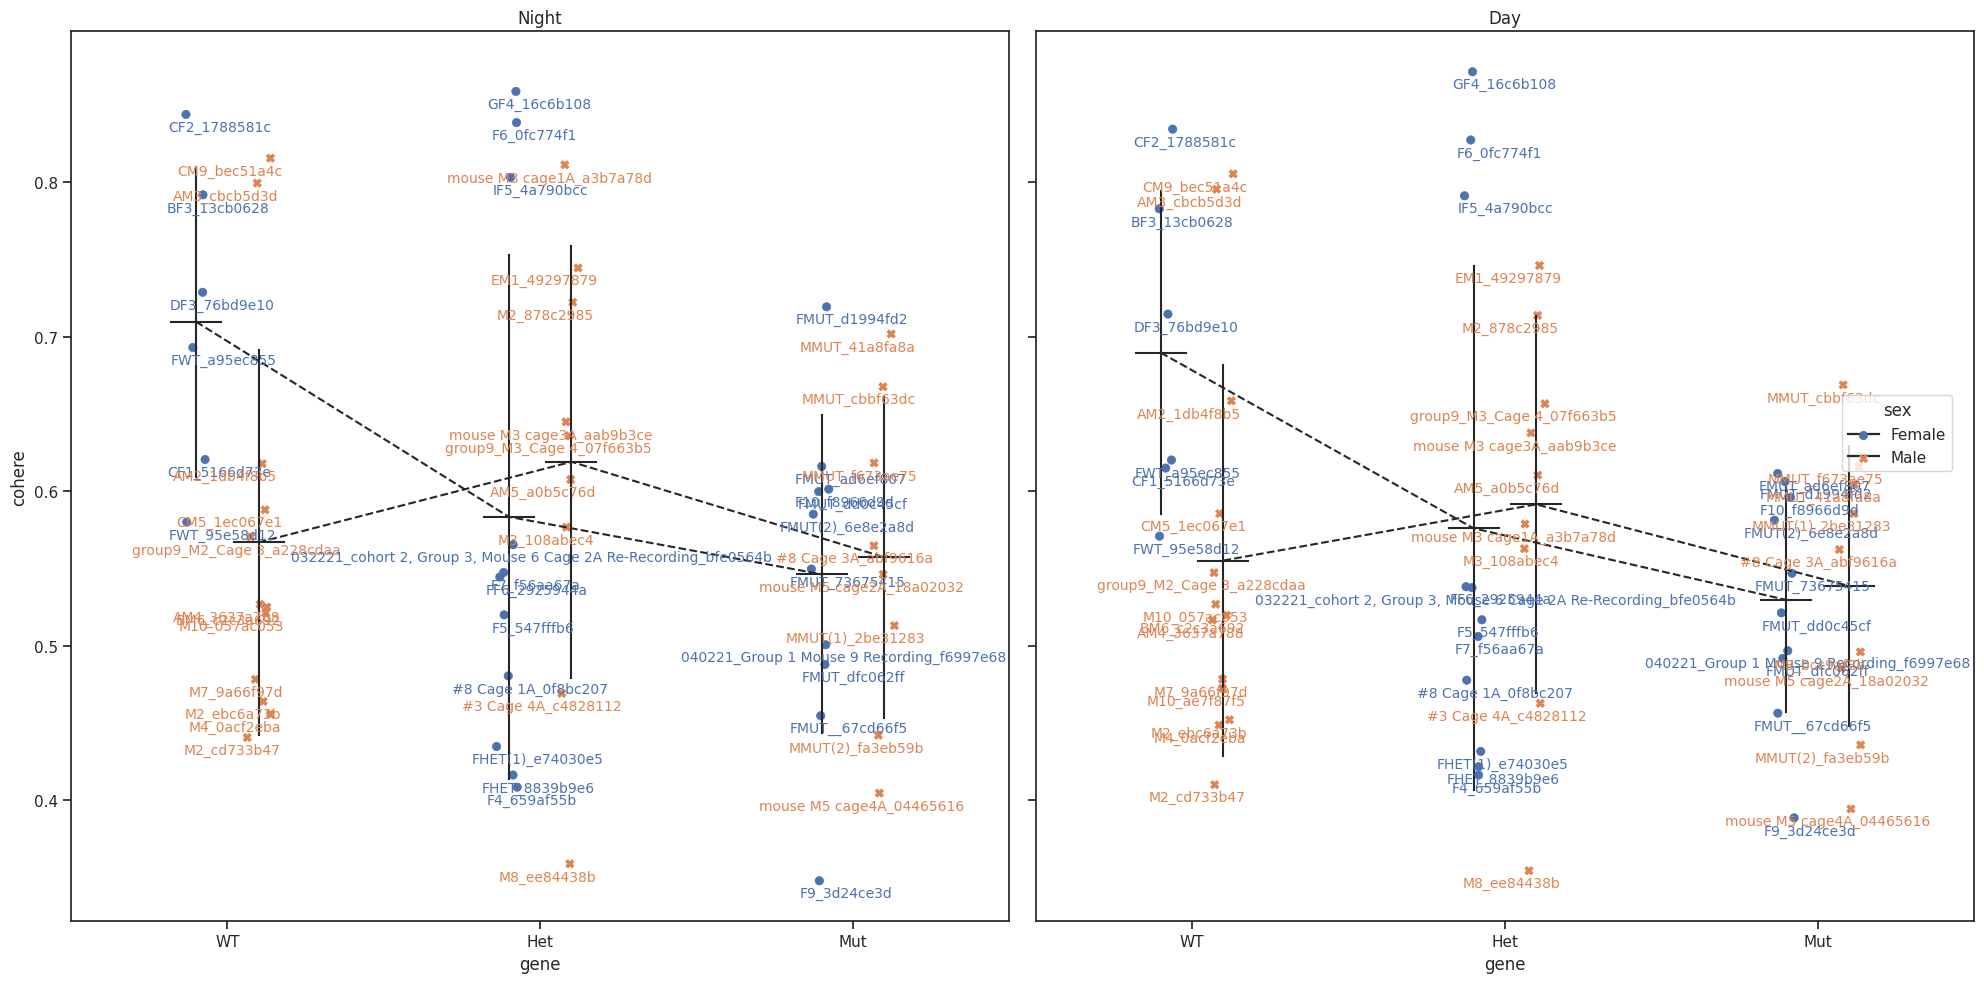

/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:179: RuntimeWarning: Mean of empty slice
  vals = np.nanmean(vals, axis=1)
/tmp/ipykernel_2034804/543566445.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby(groupby)[feature].mean().reset_index()


,animal,genotype,isday,band,psdfrac,sex,gene
20,#3 Cage 4A_c4828112,FWT,Night,delta,NaN,Female,WT
25,#3 Cage 4A_c4828112,FWT,Day,delta,NaN,Female,WT
80,#8 Cage 1A_0f8bc207,FWT,Night,delta,NaN,Female,WT
85,#8 Cage 1A_0f8bc207,FWT,Day,delta,NaN,Female,WT
140,#8 Cage 3A_abf9616a,FWT,Night,delta,NaN,Female,WT
...,...,...,...,...,...,...,...
3349,mouse M3 cage3A_aab9b3ce,MMut,Day,gamma,NaN,Male,Mut
3404,mouse M5 cage2A_18a02032,MMut,Night,gamma,0.087782,Male,Mut
3409,mouse M5 cage2A_18a02032,MMut,Day,gamma,0.089309,Male,Mut
3464,mouse M5 cage4A_04465616,MMut,Night,gamma,0.141330,Male,Mut


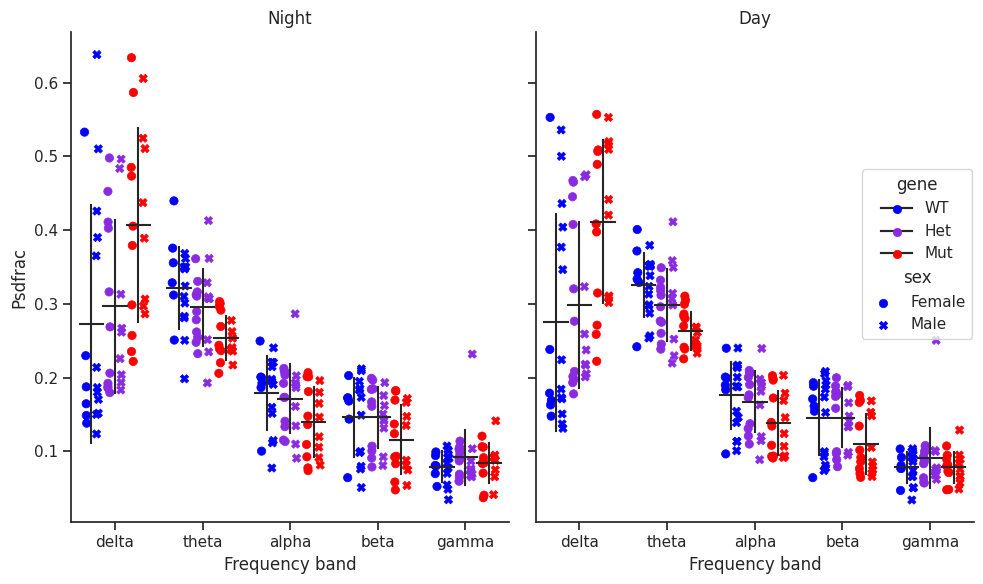

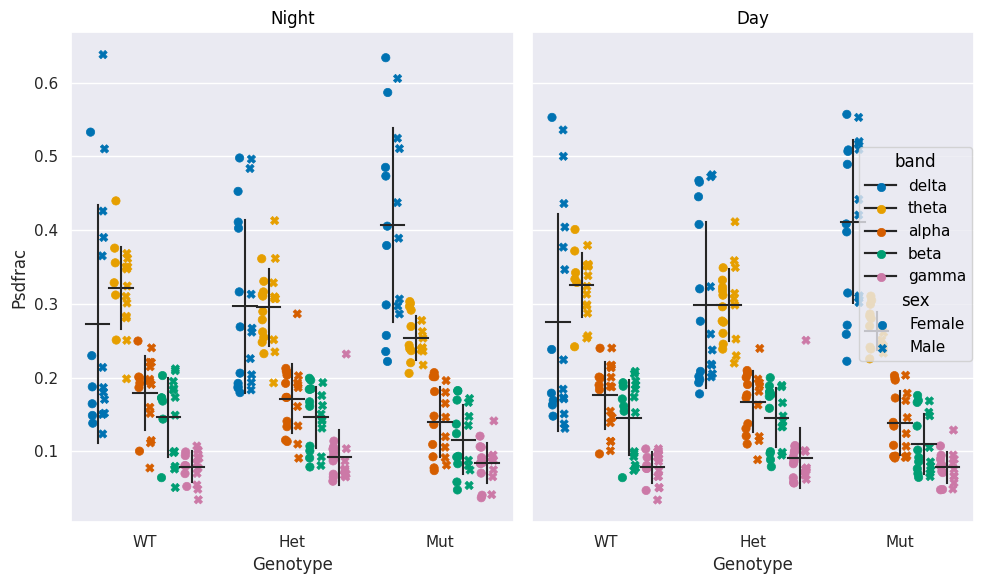

/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:179: RuntimeWarning: Mean of empty slice
  vals = np.nanmean(vals, axis=1)
/tmp/ipykernel_2034804/543566445.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby(groupby)[feature].mean().reset_index()


,animal,genotype,isday,band,logpsdband,sex,gene
20,#3 Cage 4A_c4828112,FWT,Night,delta,NaN,Female,WT
25,#3 Cage 4A_c4828112,FWT,Day,delta,NaN,Female,WT
80,#8 Cage 1A_0f8bc207,FWT,Night,delta,NaN,Female,WT
85,#8 Cage 1A_0f8bc207,FWT,Day,delta,NaN,Female,WT
140,#8 Cage 3A_abf9616a,FWT,Night,delta,NaN,Female,WT
...,...,...,...,...,...,...,...
3349,mouse M3 cage3A_aab9b3ce,MMut,Day,gamma,NaN,Male,Mut
3404,mouse M5 cage2A_18a02032,MMut,Night,gamma,6.746548,Male,Mut
3409,mouse M5 cage2A_18a02032,MMut,Day,gamma,6.444539,Male,Mut
3464,mouse M5 cage4A_04465616,MMut,Night,gamma,5.259843,Male,Mut


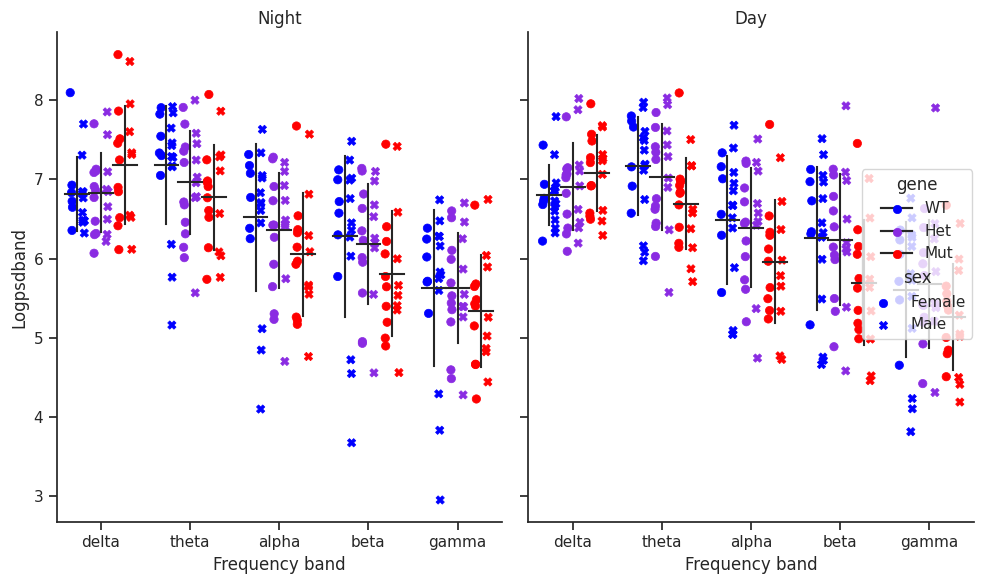

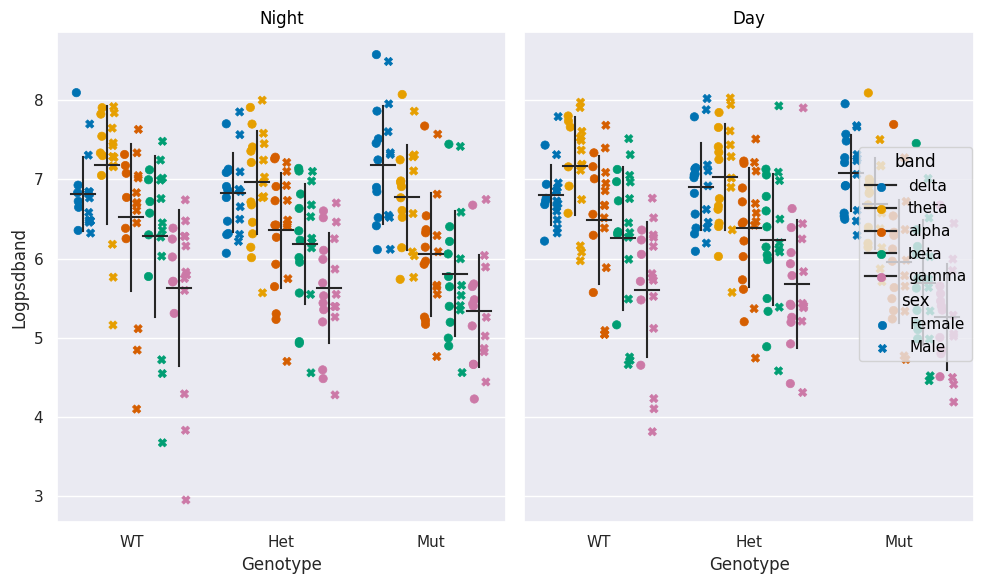

In [13]:
import matplotlib as mpl
import seaborn as sns
import seaborn.objects as so
from okabeito import black, blue, green, lightblue, orange, purple, red, yellow
from seaborn import axes_style

logger.setLevel(logging.INFO)

# features = ['psdtotal', 'psdslope', 'logpsdtotal']
# features = ["pcorr", "cohere", "psdfrac", "logpsdband"]
features = ["psdfrac", "logpsdband"]
for feature in features:
    df = ep.pull_timeseries_dataframe(feature=feature, groupby=["animal", "genotype", "isday"], collapse_channels=True)
    if feature == "psdfrac" or feature == "logpsdband":
        groupby = ["animal", "genotype", "isday", "band"]
        band_order = ["delta", "theta", "alpha", "beta", "gamma"]
        df["band"] = pd.Categorical(df["band"], categories=band_order, ordered=True)
    else:
        groupby = ["animal", "genotype", "isday"]
    df = df.groupby(groupby)[feature].mean().reset_index()

    genotype_order = ["FWT", "FHet", "FMut", "MWT", "MHet", "MMut"]
    gene_order = ["WT", "Het", "Mut"]

    df["genotype"] = pd.Categorical(df["genotype"], categories=genotype_order, ordered=True)
    df["sex"] = df["genotype"].map(lambda x: "Male" if x in ["MWT", "MHet", "MMut"] else "Female")
    df["gene"] = df["genotype"].map(
        lambda x: "WT"
        if x in ["MWT", "FWT"]
        else "Het"
        if x in ["MHet", "FHet"]
        else "Mut"
        if x in ["MMut", "FMut"]
        else x
    )
    df["gene"] = pd.Categorical(df["gene"], categories=gene_order, ordered=True)
    df["isday"] = df["isday"].map(lambda x: "Day" if x else "Night")

    if feature == "psdfrac" or feature == "logpsdband":
        df = df.sort_values(["band", "gene", "sex"])
    else:
        df = df.sort_values(["gene", "sex"])
    display(df)
    df.to_excel(Path(f"./test-{feature}.xlsx").resolve())

    if feature == "cohere" or feature == "pcorr":
        (
            so.Plot(df, x="gene", y=feature, color="sex", marker="sex")
            .facet(col="isday")
            .add(so.Dash(color="k"), so.Agg(), so.Dodge(empty="drop", gap=0.2))
            .add(so.Line(color="k", linestyle="--", marker=""), so.Agg(), so.Dodge(empty="drop", gap=0.2))
            .add(so.Range(color="k"), so.Est(errorbar="sd"), so.Dodge(empty="drop", gap=0.2))
            .add(so.Dot(), so.Dodge(empty="drop", gap=0.2), so.Jitter(0.5, seed=42))
            .add(
                so.Text(valign="top", fontsize=10),
                so.Dodge(empty="drop", gap=0.2),
                so.Jitter(0.5, seed=42),
                text="animal",
            )
            .theme(axes_style("ticks") | sns.plotting_context("notebook"))
            .layout(size=(20, 10))
            # ).save(Path(f"./test-{feature}.png").resolve(), bbox_inches="tight")
        ).show()
    elif feature == "psdfrac" or feature == "logpsdband":
        p = (
            so.Plot(df, x="band", y=feature, color="gene")
            .facet(col="isday")
            .add(so.Dash(color="k"), so.Agg(), so.Dodge())
            .add(so.Range(color="k"), so.Est(errorbar="sd"), so.Dodge())
            .add(so.Dot(), so.Dodge(), so.Jitter(seed=42), marker="sex")
            .theme(
                axes_style("ticks")
                | sns.plotting_context("notebook")
                | {"axes.prop_cycle": plt.cycler(color=["blue", "blueviolet", "red"])}
                | {"axes.spines.right": False, "axes.spines.top": False}
            )
            # .theme(plt.style.library['bmh'] | {"axes.prop_cycle": plt.cycler(color=['blue', 'blueviolet', 'red'])} | {"axes.spines.right": False, "axes.spines.top": False})
            .layout(size=(10, 6), engine="tight")
            .label(x="Frequency band", y=str.capitalize)
            # ).save(Path(f"./test-byband-{feature}.png").resolve(), bbox_inches="tight")
        ).show()

        with mpl.rc_context(plt.style.library["bmh"] | sns.plotting_context("notebook")):
            # fig, ax = plt.subplots(figsize=(8, 6))
            # fig = plt.figure(figsize=(10, 6))
            # subfigs = fig.subfigures(1,1)
            (
                so.Plot(df, x="gene", y=feature, color="band")
                # .facet(col="isday", row="sex")
                .facet(col="isday")
                .add(so.Dash(color="k"), so.Agg(), so.Dodge())
                .add(so.Range(color="k"), so.Est(errorbar="sd"), so.Dodge())
                .add(so.Dot(), so.Dodge(), so.Jitter(seed=42), marker="sex")
                # .theme(plt.style.library['bmh'])
                .theme(
                    {"axes.prop_cycle": plt.cycler(color=[blue, orange, red, green, purple, yellow, lightblue, black])}
                )
                .layout(size=(10, 6), engine="tight")
                .label(x="Genotype", y=str.capitalize)
                # ).save(Path(f"./test-bygeno-{feature}.png").resolve(), bbox_inches="tight")
            ).show()

In [15]:
# for feat in constants.LINEAR_FEATURE + ['psdband']:
#     logging.info(f'pulling {feat}')
#     df = ep._pull_timeseries_dataframe(feat, 'animal')
#     # display(df)
#     # ep.plot_boxplot_2(feat, ['genotype', 'animalday'], collapse_channels=False)
#     ep.plot_catplot(feat, 'animal', kind='violin')

# ep.plot_catplot('psdband', ['animal', 'isday', 'animalday'], 
#                 x='animal',
#                 col='isday',
#                 hue='band',
#                 kind='boxen',
#                 collapse_channels=False,
#                 catplot_params={'showfliers': False})

In [16]:
# for feat in ['cohere']:
#     logging.info(f'pulling {feat}')
#     df = ep._pull_timeseries_dataframe(feat, ['animal', 'isday'])
#     ep.plot_2d_feature_2(feat, ['animal', 'isday'], row='band')

In [ ]:
ep.plot_heatmap('cohere', groupby=['animalday', 'isday'])
ep.plot_heatmap('cohere', groupby='animalday', col='band', row='animalday')

ep.plot_heatmap('pcorr', groupby=['genotype', 'isday'])
ep.plot_heatmap('pcorr', groupby='genotype')

KeyboardInterrupt: 

2025-06-11 22:19:22,257 - DEBUG - groups: ['KO', 'WT']
2025-06-11 22:19:22,276 - DEBUG - vals.shape: (1, 10)
2025-06-11 22:19:22,282 - DEBUG - vals.shape: (1, 10)
2025-06-11 22:19:22,286 - DEBUG - vals.shape: (1, 10)
2025-06-11 22:19:22,749 - DEBUG - groups: ['KO', 'WT']
2025-06-11 22:19:22,750 - DEBUG - vals.shape: (1,)
2025-06-11 22:19:22,751 - DEBUG - vals.shape: (1,)
2025-06-11 22:19:22,753 - DEBUG - vals.shape: (1,)
2025-06-11 22:19:22,924 - DEBUG - groups: [('KO', True), ('WT', True)]
2025-06-11 22:19:22,925 - DEBUG - vals.shape: (1, 10)
2025-06-11 22:19:22,927 - DEBUG - vals.shape: (1, 10)
2025-06-11 22:19:22,928 - DEBUG - vals.shape: (1, 10)
2025-06-11 22:19:23,306 - DEBUG - groups: [('KO', True), ('WT', True)]
2025-06-11 22:19:23,307 - DEBUG - vals.shape: (1,)
2025-06-11 22:19:23,309 - DEBUG - vals.shape: (1,)
2025-06-11 22:19:23,311 - DEBUG - vals.shape: (1,)
2025-06-11 22:19:23,512 - DEBUG - groups: ['KO', 'WT']
2025-06-11 22:19:23,513 - DEBUG - vals.shape: (1, 10)
2025-06-1

/mnt/isilon/marsh_single_unit/PythonEEG/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:453: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


2025-06-11 22:19:29,765 - DEBUG - groups: ['KO', 'WT']
2025-06-11 22:19:29,770 - DEBUG - vals.shape: (1,)
2025-06-11 22:19:29,772 - DEBUG - vals.shape: (1,)
2025-06-11 22:19:29,774 - DEBUG - vals.shape: (1,)
2025-06-11 22:19:30,006 - DEBUG - groups: [('KO', True), ('WT', True)]
2025-06-11 22:19:30,008 - DEBUG - vals.shape: (1, 10)
2025-06-11 22:19:30,010 - DEBUG - vals.shape: (1, 10)
2025-06-11 22:19:30,014 - DEBUG - vals.shape: (1, 10)
2025-06-11 22:19:30,484 - DEBUG - groups: [('KO', True), ('WT', True)]
2025-06-11 22:19:30,485 - DEBUG - vals.shape: (1,)
2025-06-11 22:19:30,486 - DEBUG - vals.shape: (1,)
2025-06-11 22:19:30,488 - DEBUG - vals.shape: (1,)
2025-06-11 22:19:30,720 - DEBUG - groups: ['KO', 'WT']
2025-06-11 22:19:30,721 - DEBUG - vals.shape: (1, 10, 2)
2025-06-11 22:19:30,723 - DEBUG - vals.shape: (1, 10, 2)
2025-06-11 22:19:30,725 - DEBUG - vals.shape: (1, 10, 2)
2025-06-11 22:19:31,130 - DEBUG - groups: ['KO', 'WT']
2025-06-11 22:19:31,131 - DEBUG - vals.shape: (1, 2)
2

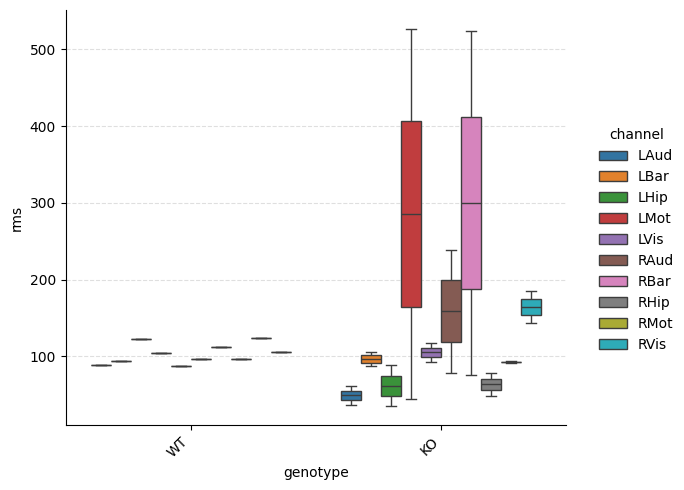

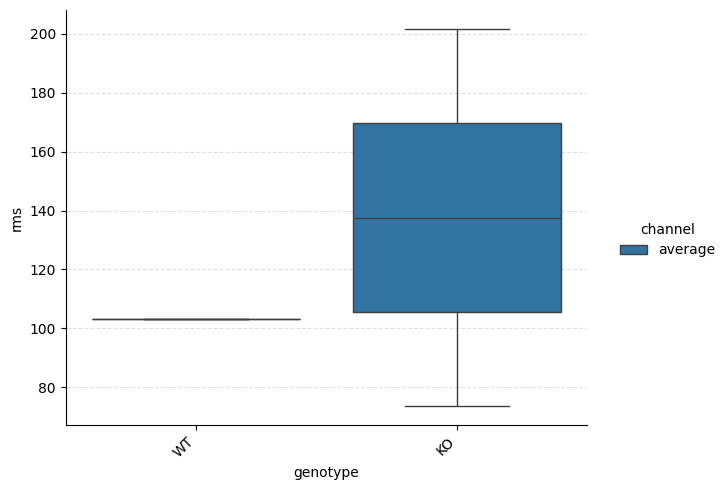

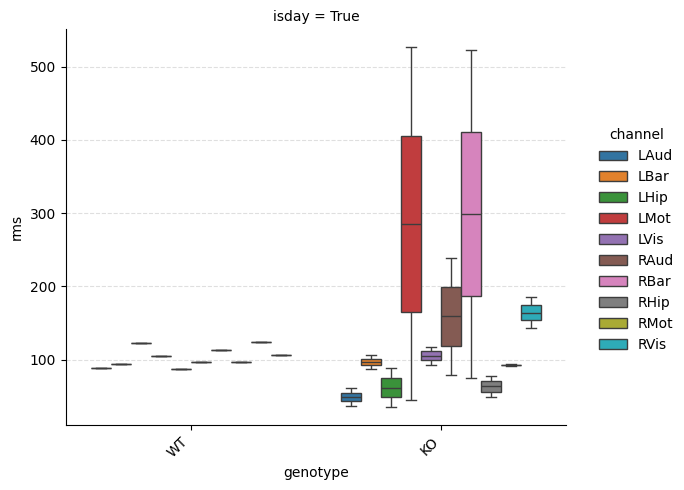

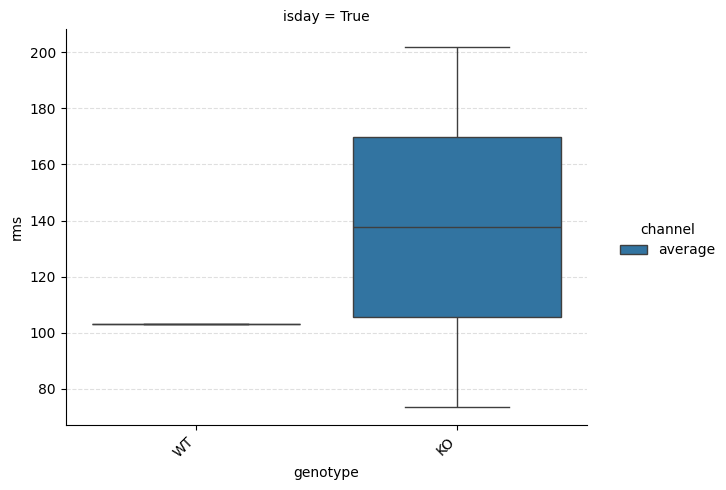

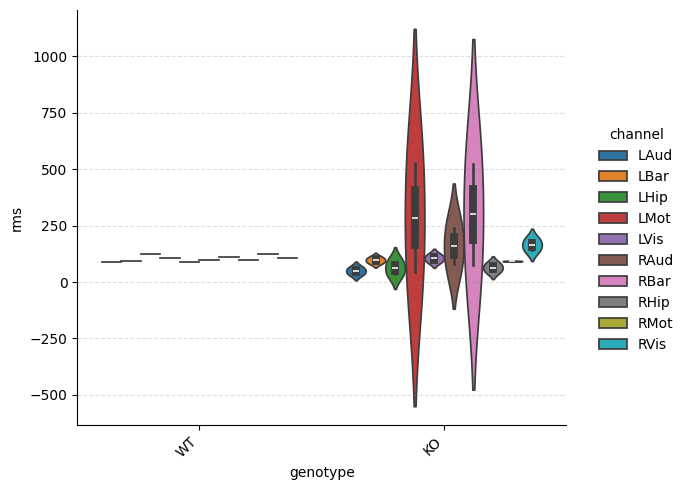

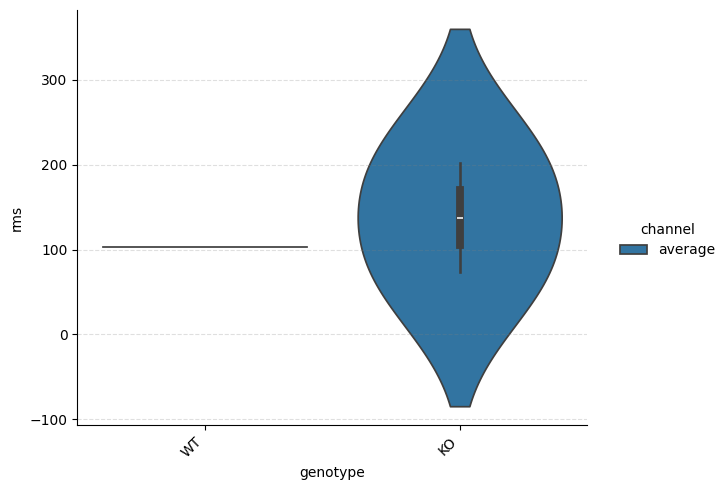

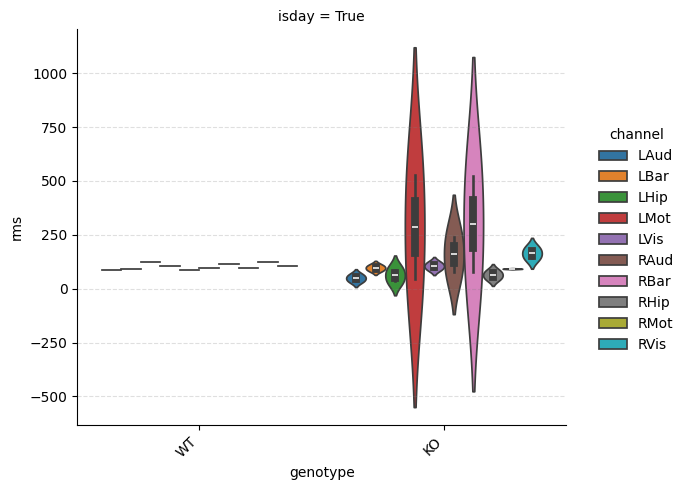

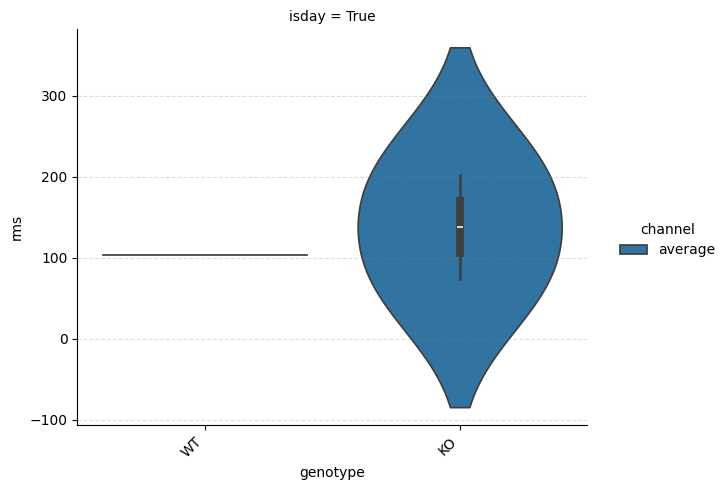

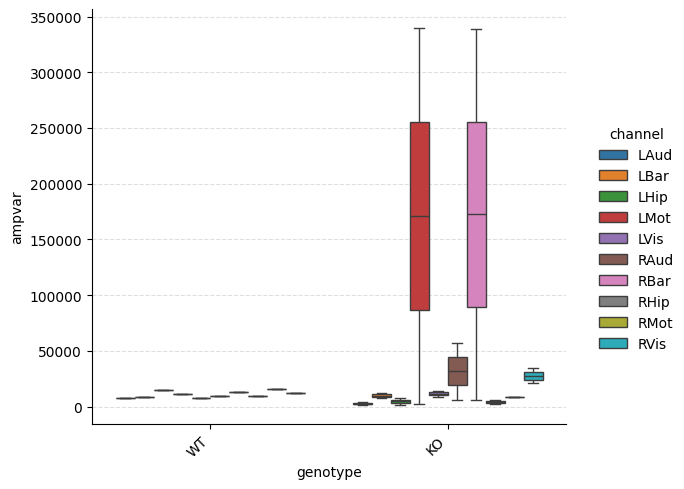

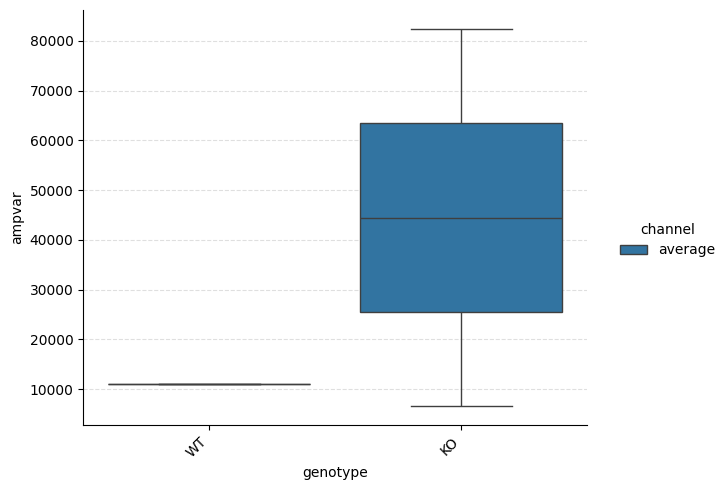

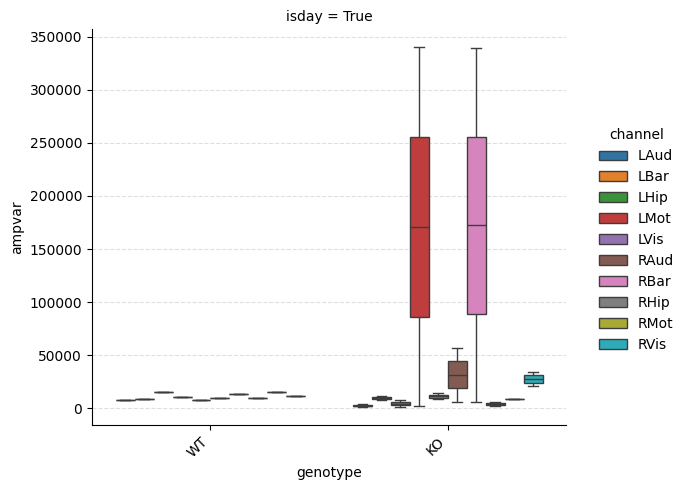

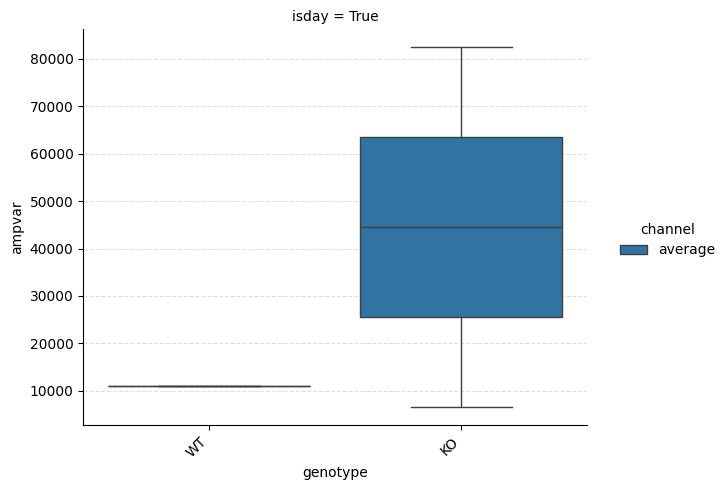

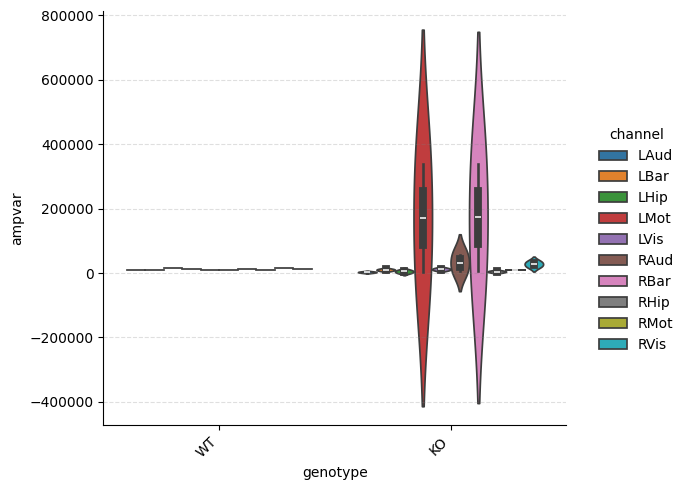

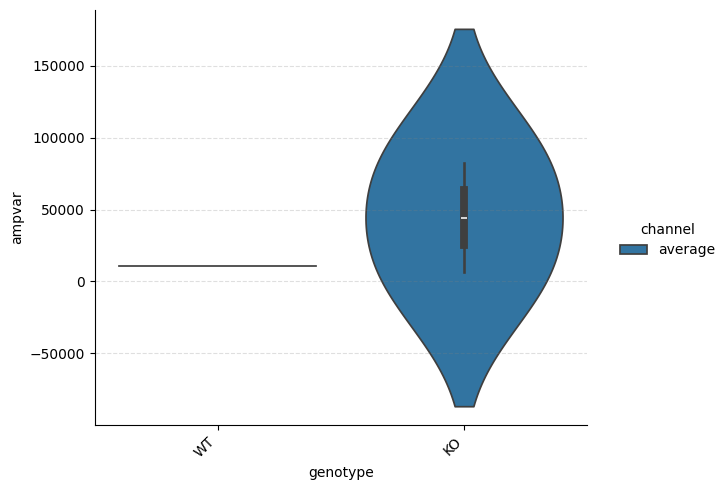

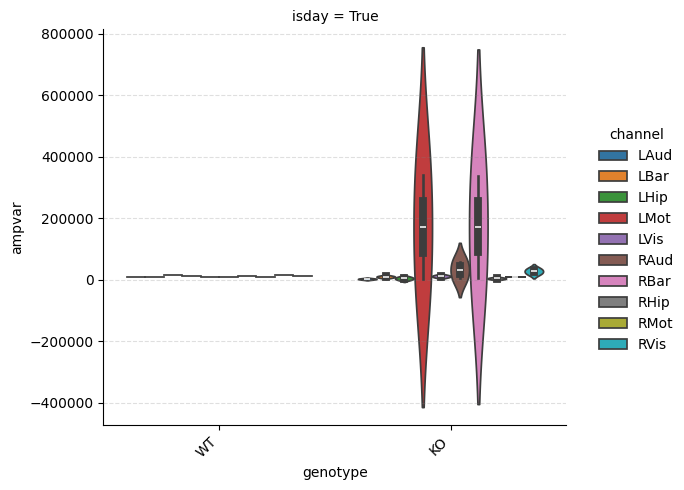

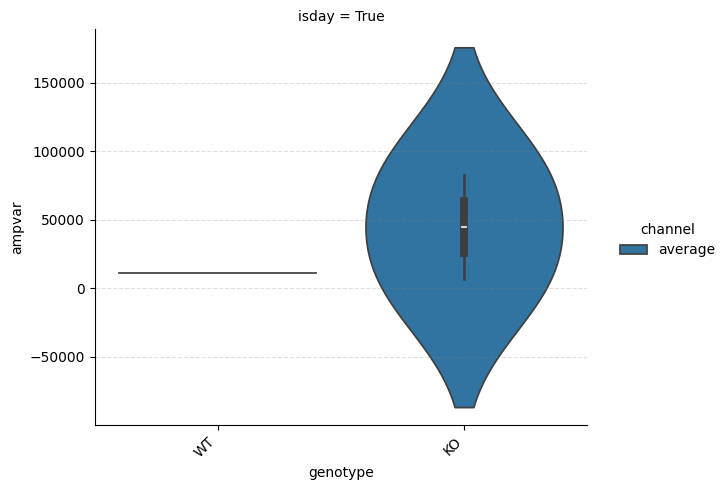

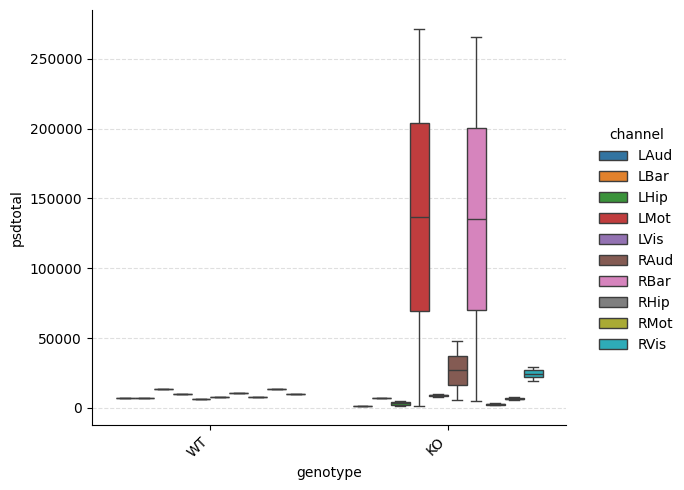

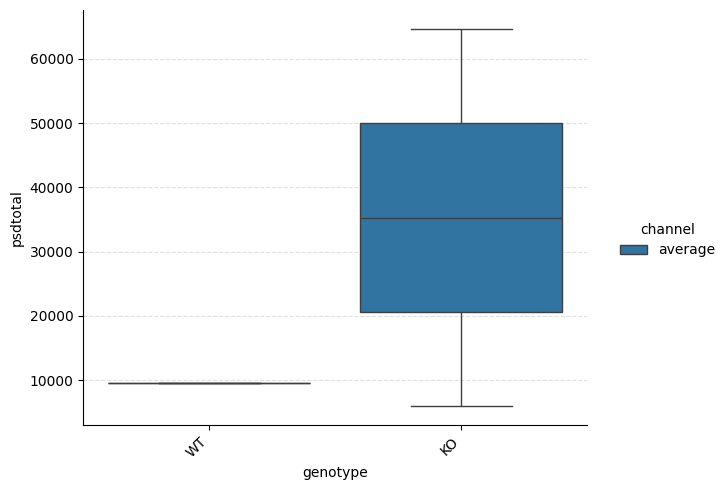

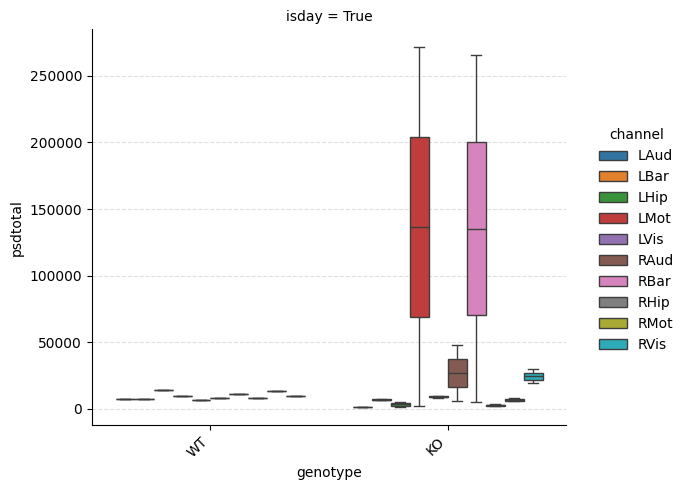

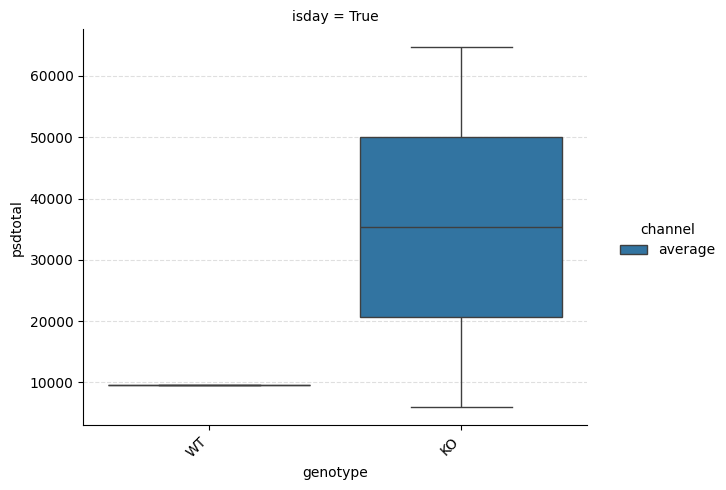

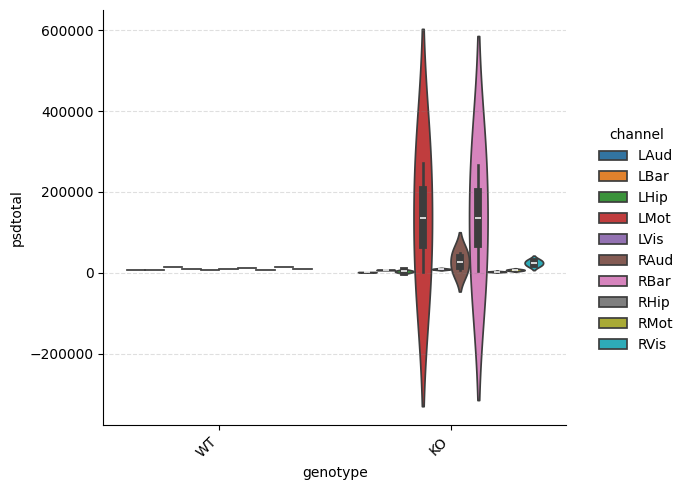

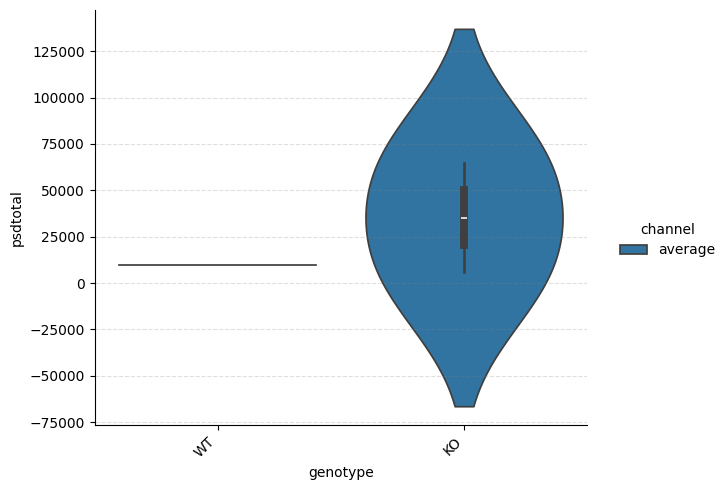

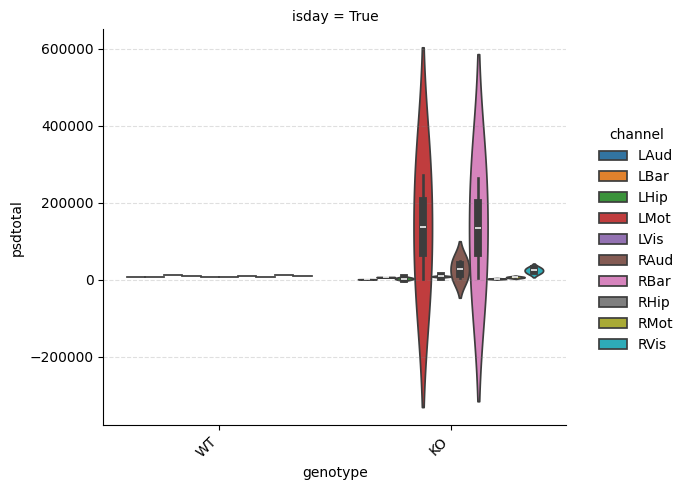

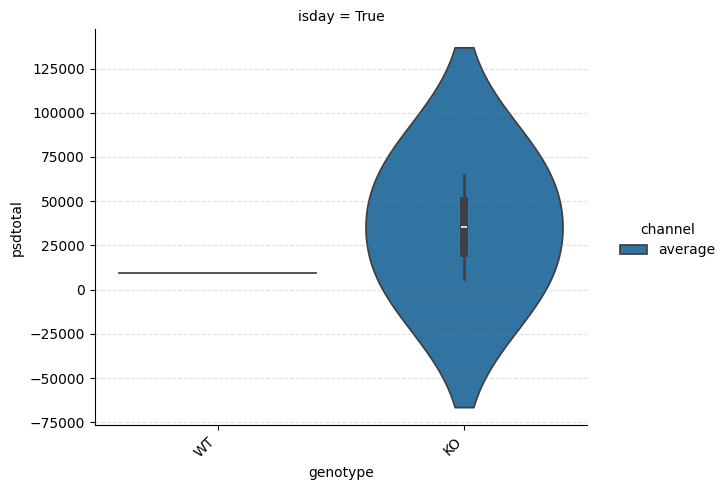

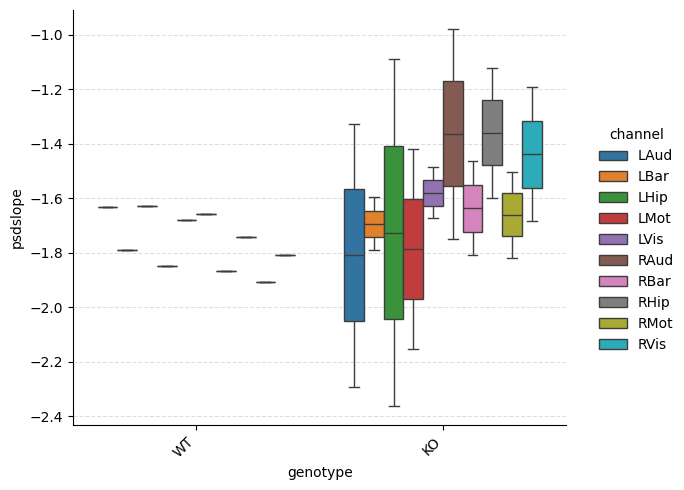

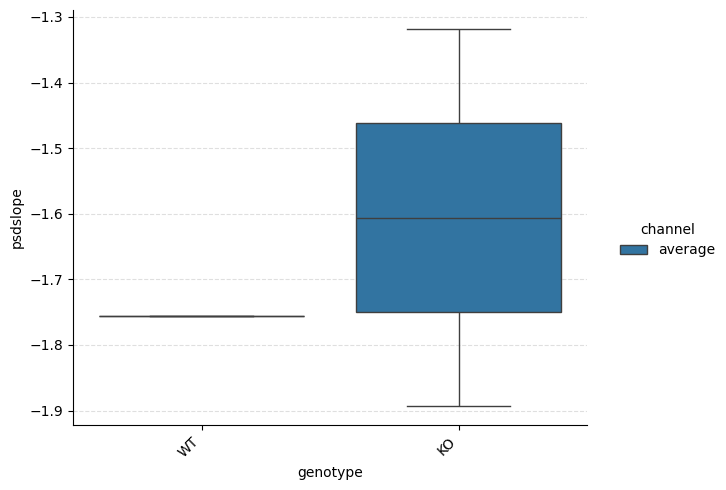

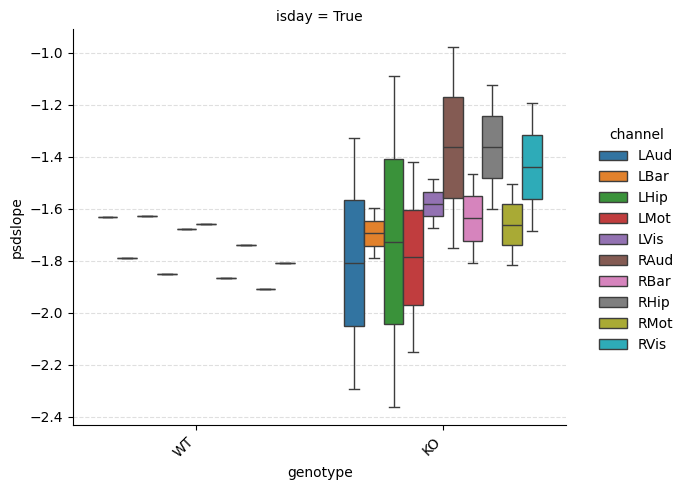

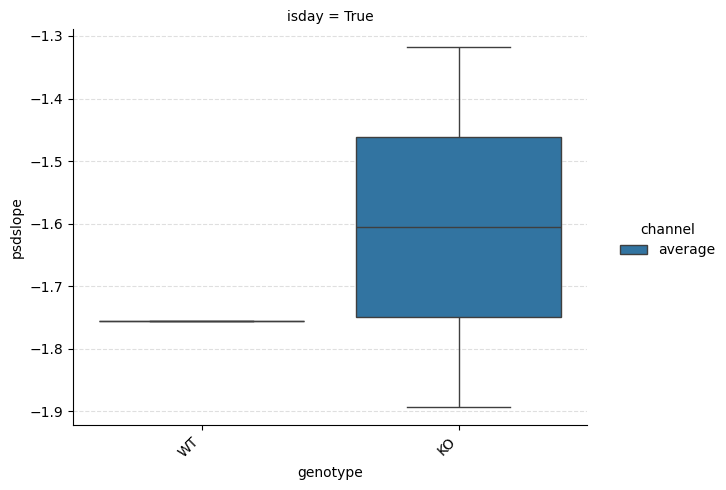

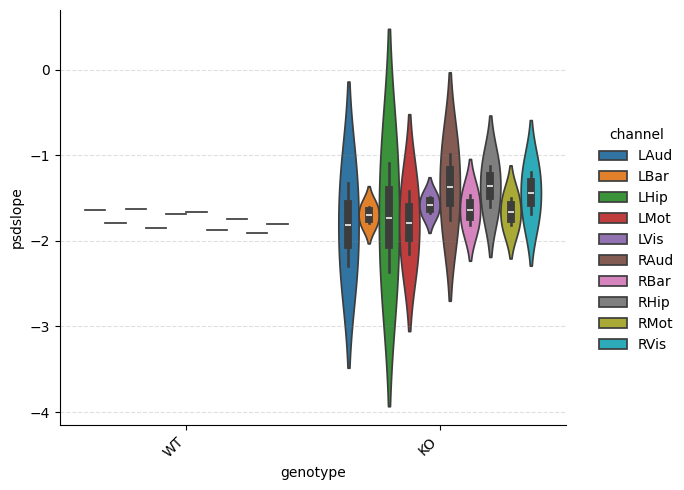

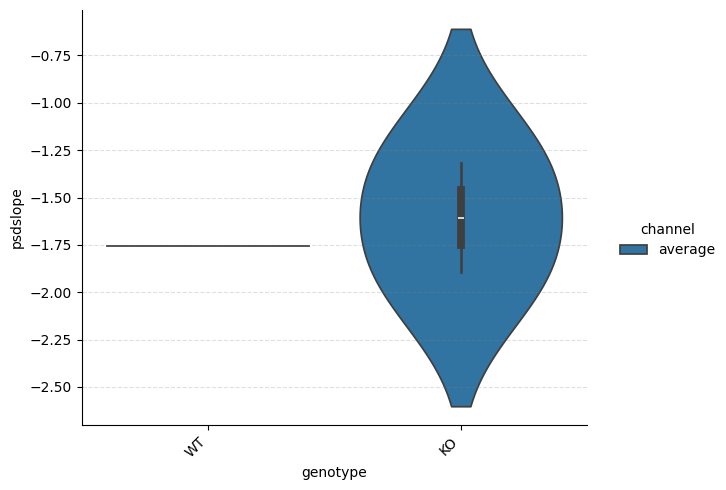

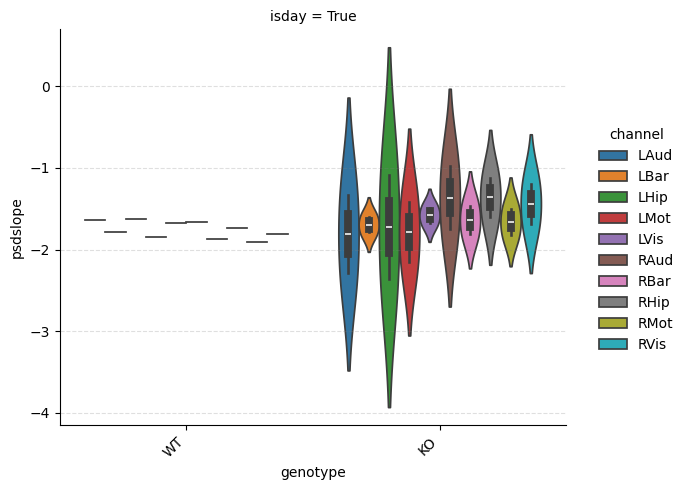

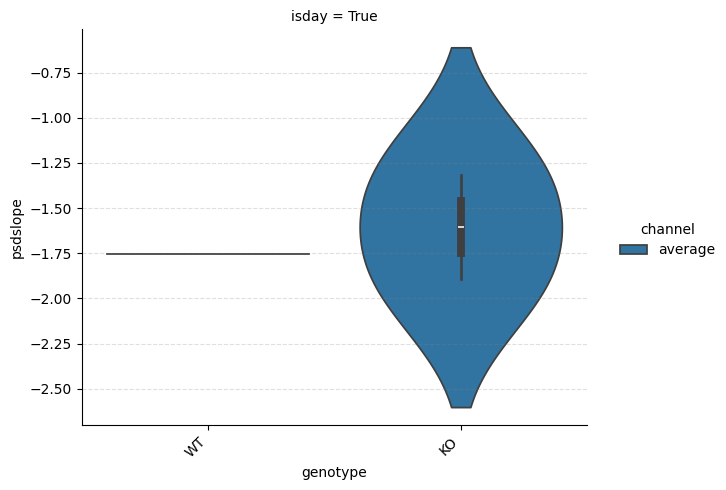

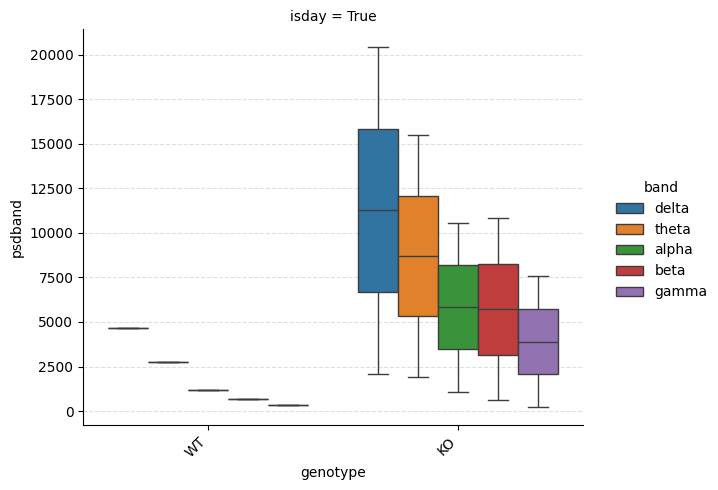

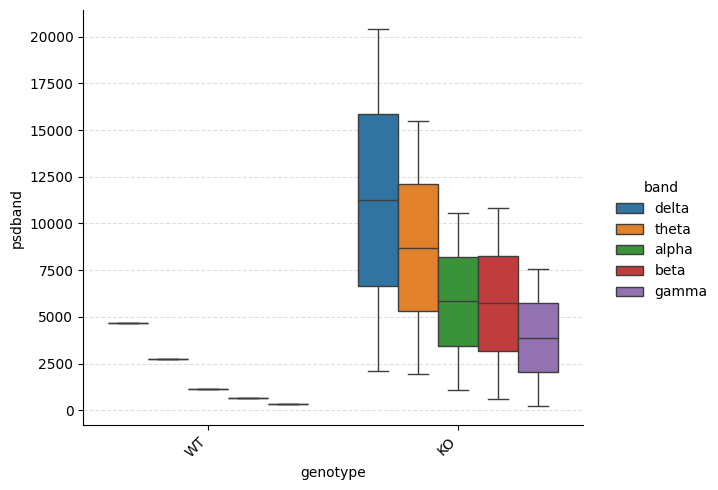

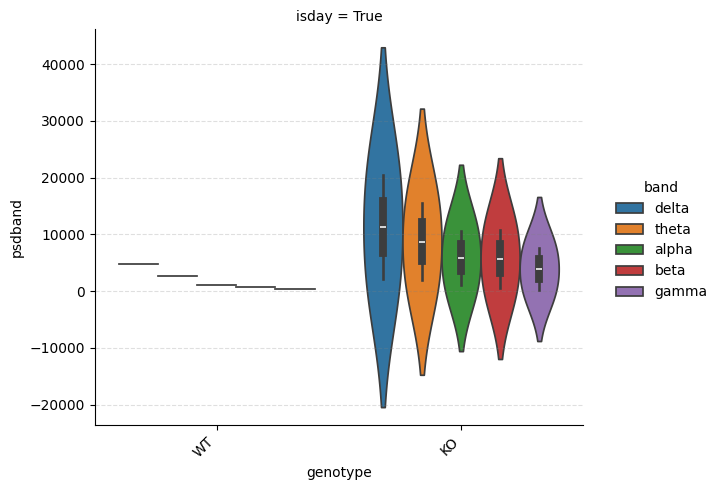

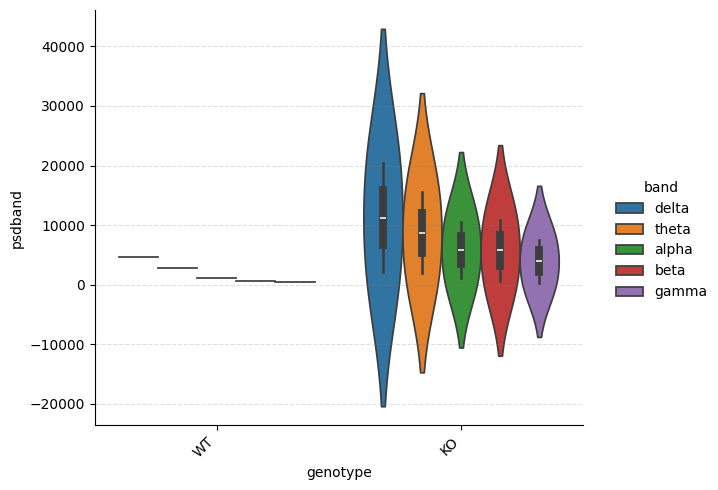

In [18]:
for feature in constants.LINEAR_FEATURES:
    if feature in ['nspike', 'psdfrac', 'logrms', 'logampvar', 'logpsdtotal', 'lognspike', 'logpsdband', 'logpsdfrac']:
        print(f"Skipping feature {feature}")
        continue
    for kind in ['box', 'violin']:
        for groupby in ['genotype', ['genotype', 'isday']]:
            for collapse in [False, True]:
                ep.plot_catplot(feature, groupby=groupby, kind=kind, collapse_channels=collapse)
for kind in ['box', 'violin']:
    ep.plot_catplot('psdband', groupby=['genotype', 'isday'], 
                    x='genotype',
                    col='isday',
                    hue='band',
                    kind=kind, collapse_channels=True)
    ep.plot_catplot('psdband', groupby=['genotype'], 
                    x='genotype',
                    hue='band',
                    kind=kind, collapse_channels=True)

2025-06-11 22:19:40,419 - DEBUG - groups: ['A10', 'A5', 'F22']
2025-06-11 22:19:40,420 - DEBUG - vals.shape: (1, 10)
2025-06-11 22:19:40,422 - DEBUG - vals.shape: (1, 10)
2025-06-11 22:19:40,424 - DEBUG - vals.shape: (1, 10)


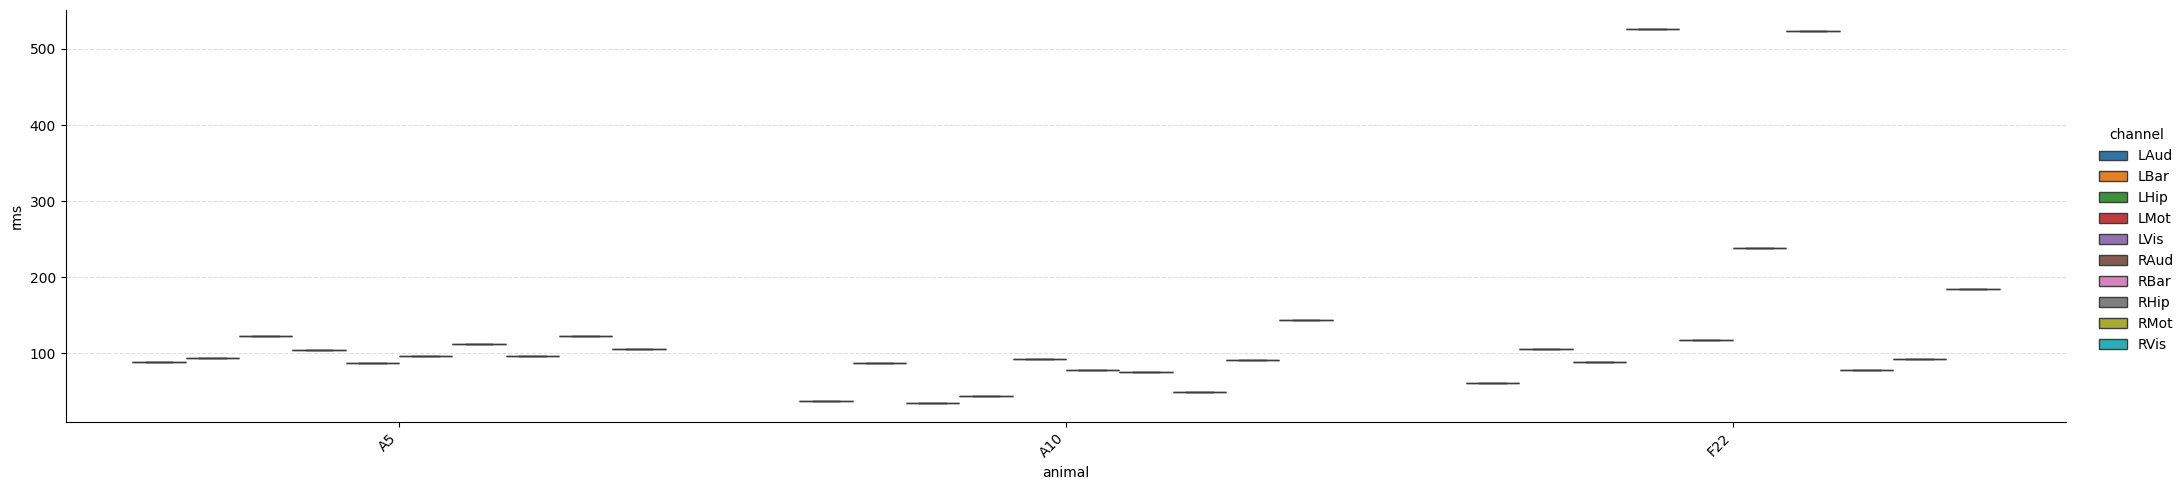

In [19]:
ep.plot_catplot('rms', groupby='animal', kind='box', catplot_params={'showfliers': False, 'aspect': 4})

2025-06-11 22:19:41,010 - DEBUG - groups: ['A10', 'A5', 'F22']
2025-06-11 22:19:41,011 - DEBUG - vals.shape: (1, 10, 10)
2025-06-11 22:19:41,013 - DEBUG - vals.shape: (1, 10, 10)
2025-06-11 22:19:41,014 - DEBUG - vals.shape: (1, 10, 10)
2025-06-11 22:19:41,174 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f6cdfaaf6d0>
2025-06-11 22:19:41,196 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f6cdfaf3280>
2025-06-11 22:19:41,219 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f6cdf970a90>
2025-06-11 22:19:41,458 - DEBUG - groups: ['A10', 'A5', 'F22']
2025-06-11 22:19:41,459 - DEBUG - vals.shape: (1, 5, 10, 10)
2025-06-11 22:19:41,460 - DEBUG - vals.shape: (1, 5, 10, 10)
2025-06-11 22:19:41,461 - DEBUG - vals.shape: (1, 5, 10, 10)
2025-06-11 22:19:41,462 - DEBUG - vals.shape: (1, 5, 10, 10)
2025-06-11 22:19:41,463 - DEBUG - vals.shape: (1, 5, 10, 10)
2025-06-11 22:19:41,464 - DEBUG - vals.shape: (1, 5, 10, 10)
2025-06-11 22:19:42,198 - DEBUG - 

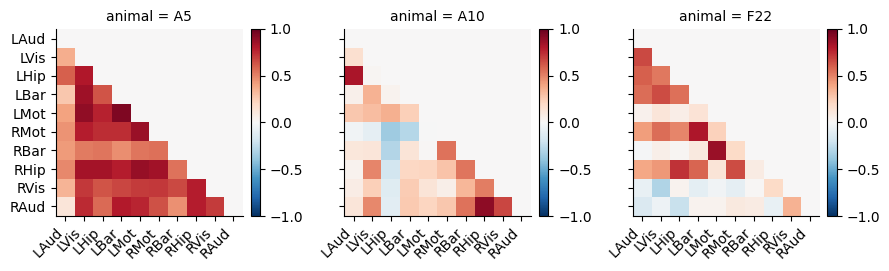

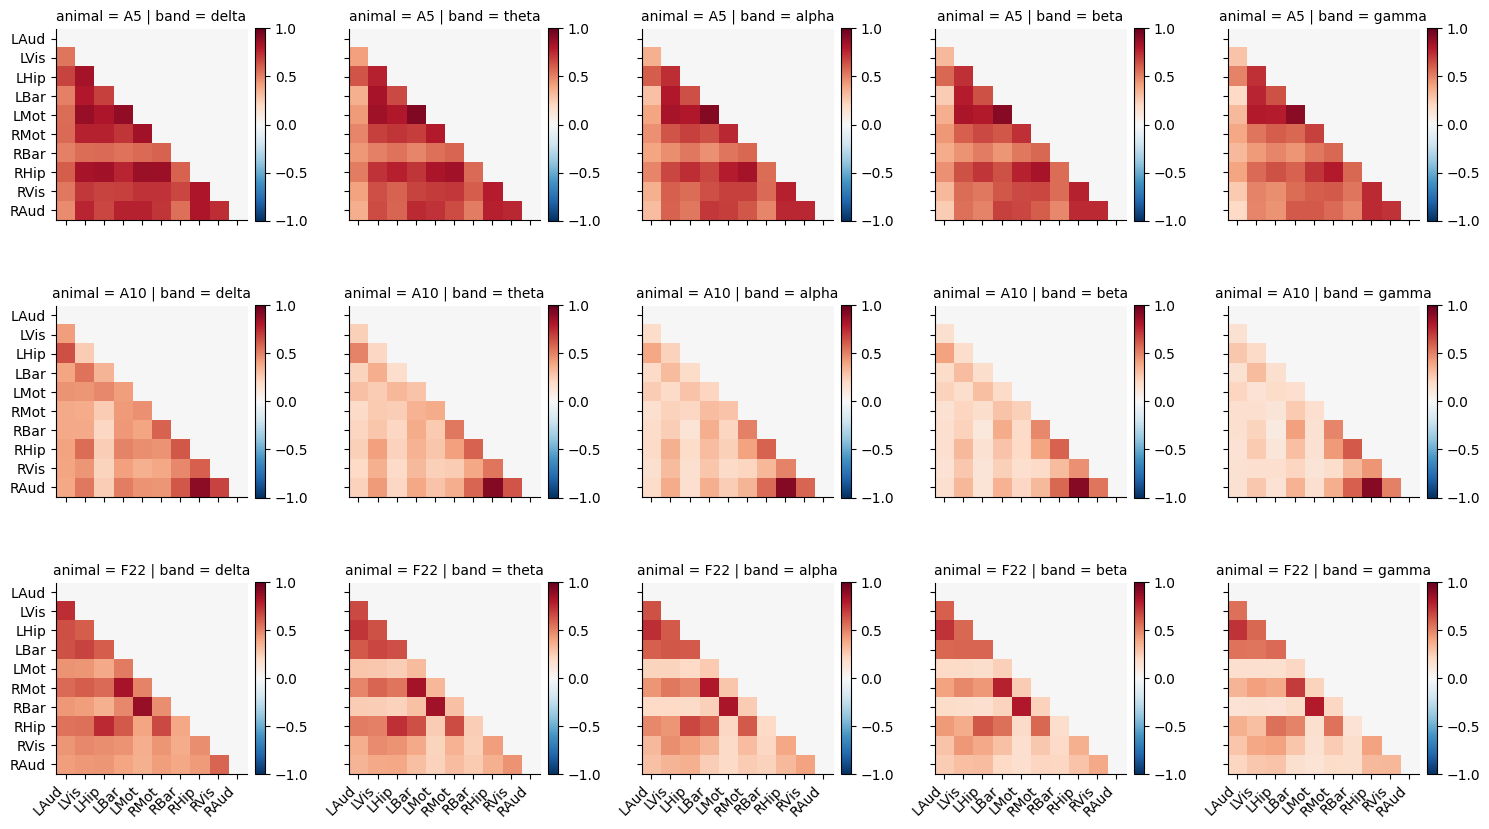

In [20]:
ep.plot_heatmap('pcorr', groupby='animal')
ep.plot_heatmap('cohere', groupby='animal', col='band', row='animal')

In [21]:
logger.setLevel(logging.DEBUG)

In [22]:
for e in sar:
    e.convert_to_mne(chunk_len=1440)
    e.save_fif_and_json(Path(f'./test-mnes/{e.animal_day}').resolve(), overwrite=True)

NameError: name 'sar' is not defined

In [17]:
reconstruct_sas = visualization.SpikeAnalysisResult.load_fif_and_json('./test-mnes/A5 WT Dec-12-2023')
mne_obj = reconstruct_sas.result_mne

Opening raw data file test-mnes/A5 WT Dec-12-2023/A5-WT-A5 WT Dec-12-2023-raw.fif...
    Reading extended channel information
Isotrak not found
    Range : 0 ... 40067758 =      0.000 ... 40067.758 secs
Ready.
2025-03-21 21:23:35,173 - INFO - Channel names: 	['Intan Input (1)/PortB L Aud Ctx', 'Intan Input (1)/PortB L Vis Ctx', 'Intan Input (1)/PortB L Hipp', 'Intan Input (1)/PortB L Barrel', 'Intan Input (1)/PortB L Motor', 'Intan Input (1)/PortB R Motor', 'Intan Input (1)/PortB R Barrel', 'Intan Input (1)/PortB R Hipp', 'Intan Input (1)/PortB R Vis Ctx', 'Intan Input (1)/PortB R Aud Ctx']
2025-03-21 21:23:35,174 - INFO - Channel abbreviations: 	['LAud', 'LVis', 'LHip', 'LBar', 'LMot', 'RMot', 'RBar', 'RHip', 'RVis', 'RAud']


Used Annotations descriptions: [np.str_('Intan Input (1)/PortB L Aud Ctx'), np.str_('Intan Input (1)/PortB L Barrel'), np.str_('Intan Input (1)/PortB L Hipp'), np.str_('Intan Input (1)/PortB L Motor'), np.str_('Intan Input (1)/PortB L Vis Ctx'), np.str_('Intan Input (1)/PortB R Aud Ctx'), np.str_('Intan Input (1)/PortB R Barrel'), np.str_('Intan Input (1)/PortB R Hipp'), np.str_('Intan Input (1)/PortB R Motor'), np.str_('Intan Input (1)/PortB R Vis Ctx')]


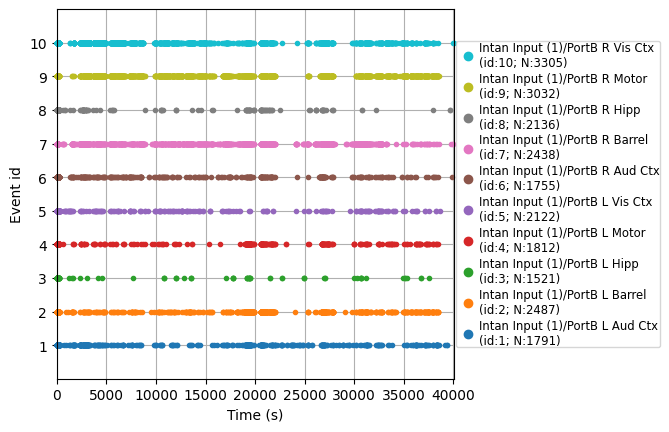

In [18]:
logger.setLevel(logging.WARNING)
events, event_id = mne.events_from_annotations(raw=mne_obj)
fig = mne.viz.plot_events(events, sfreq=mne_obj.info['sfreq'], first_samp=mne_obj.first_samp, event_id=event_id)